In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict
from IPython.core.display import display, HTML
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
#display(HTML(my_html))     # make sure Jupyter knows to display it as HTML

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

In [2]:
dirs = {'fassbinder': 'https://www.imdb.com/name/nm0001202/', \
        'godard':'https://www.imdb.com/name/nm0000419/', \
        'hitchcock': 'https://www.imdb.com/name/nm0000033', \
        'spielberg': 'https://www.imdb.com/name/nm0000229', \
        'kurosawa': 'https://www.imdb.com/name/nm0000041/', \
        'bergman': 'https://www.imdb.com/name/nm0000005/', \
        'allen': 'https://www.imdb.com/name/nm0000095',\
        'herzog': 'https://www.imdb.com/name/nm0001348/'}
        # scorcese

dirs_box_office = {'godard':'https://www.the-numbers.com/person/55430401-Jean-Luc-Godard#tab=technical', \
                   'hitchcock':'https://www.the-numbers.com/person/66230401-Alfred-Hitchcock#tab=technical', \
                   'spielberg': 'https://www.the-numbers.com/person/135430401-Steven-Spielberg#tab=technical',\
                   'allen':'https://www.the-numbers.com/person/4010401-Woody-Allen#tab=technical', \
                   'bergman': 'https://www.the-numbers.com/person/13600401-Ingmar-Bergman#tab=technical',\
                   'herzog':'https://www.the-numbers.com/person/65080401-Werner-Herzog#tab=technical'}

In [3]:
director = 'herzog'

In [4]:

dirs_page = dirs[director]
url = dirs_page
response = requests.get(url)
print( response.status_code )
page = response.text
soup = BeautifulSoup(page, "lxml")
#need to distinguish 'filmo-head-director' from 'assistant_director' etc.
head_director_soup = soup.find('div', id='filmo-head-director')
head_director_section_soup= head_director_soup.find_next_sibling('div', class_='filmo-category-section')
films = head_director_section_soup.find_all('div', class_=re.compile('filmo-row'), id=re.compile("director"))
#films = soup.find_all('div', class_=re.compile('filmo-row'), id=re.compile("director"))

200


* Clean the datapoints below
* Ensure they are available or handled for each film's page
* Convert into numeric datatypes
* Populate a list of dictionaries with these 
* Within the loop that goes through every flick, populate the list of dictionaries with these
* Do one-hot-encoding on categorical variables
* Train and test the linear regression model

In [5]:
def is_tv_series( the_film_soup ):
    try:
        parenthesis = the_film_soup.find('a').next
        try:
            if 'TV ' in parenthesis.next:
                return True
            else:
                return False
        except:
            return False
    except:
        return False

In [6]:
def is_documentary( the_film_soup ):
    try:
        parenthesis = the_film_soup.find('a').next
        #print(parenthesis)
        try:
            if 'documentary' in parenthesis.next.lower():
                return 1
            else:
                return 0
        except:
            return 0
    except:
        return 0

In [7]:
def parse_crew_data(the_crew_soup):
    crew_data = {}
    try: 
        #print( the_crew_soup.find('h4', id='cinematographer').next_sibling )
        crew_data['cinematographer'] = the_crew_soup.find('h4', id='cinematographer').find_next_sibling('table', class_='simpleTable').find('a').text.strip()
    except: 
        crew_data['cinematographer'] = ''
    return (crew_data)

In [8]:
def parse_cast_data(the_film_soup):
    try:
        cast_table = the_film_soup.find('table', class_='cast_list').find_all('td', class_='primary_photo')
        cast_list = [(row.find_next_sibling().text.strip(), 1) for row in cast_table ]
        #cast_dict= defaultdict(cast_list)
        #cast_dict.setdefault(1)
        cast_dict = dict(cast_list)
        #print(cast_dict)
        return(cast_dict)
        #return(  the_film_soup.find('table', class_='cast_list').find_all('a', class_='primary_photo').find_next_sibling().text )
        
  #     the_film_soup.find('table', class_='cast_list').find_all('a', class_=re.compile('filmo-row'), id=re.compile("director"))
  #  return the_film_soup.find('table', class_='cast_list').find('a')
    except:
        return dict()

In [9]:
#crew_url = test_url + '/fullcredits'
crew_url = 'https://www.imdb.com/title/tt0084654/fullcredits'
crew_response = requests.get(crew_url)
crew_page = crew_response.text
crew_soup = BeautifulSoup(crew_page, "lxml")

the_crew_data = parse_crew_data( crew_soup )
#print(the_crew_data)
#print(is_tv_series(test_row))

In [10]:
def get_film_data_only_title( film_soup ):
    film_title_string = film_soup.find(class_ = 'title_wrapper').find('h1').text
    print(film_title_string)
    
# searching from the page_content might be more efficient. To be tested later
def parse_film_data( film_soup ):
    film_data = {}
    
    try:        
        film_title_string = (film_soup.find(class_ = 'title_wrapper').find('h1').text).strip()
    except:
        film_title_string = ''
    title_line = film_title_string.split('\xa0(')
    film_data['title'] = title_line[0].replace('\xa0','').rstrip() # title part of title line
    
    film_data['year'] = title_line[1].replace(') ', '').strip(')') if len(title_line) > 1 else '' # year part of title line
    
    try:
        film_rating_tag = film_soup.find('span', itemprop='ratingValue')
        try:
            film_rating_string = film_rating_tag.text   #find_next_sibling().text
        except:
            film_rating_string = None      
    except:
        film_rating_string = None 
    film_data['rating'] = film_rating_string
   
    try:
        film_rating_count_tag = film_soup.find('span', itemprop='ratingCount')
        try:
            film_rating_count = float( film_rating_count_tag.text.replace(',', '')) #find_next_sibling().text
        except:
            film_rating_count = None 
    except:
            film_rating_count = None 
    film_data['rating_count'] = film_rating_count
    
    try:
        film_duration_string = film_soup.find('time').text
        dur_list = film_duration_string.replace('min','').rstrip().split('h ')
        film_data['duration'] = (int(dur_list[-1]) + 60*int(dur_list[0])) if (len(dur_list)>1) else int(dur_list[-1])
    except:
        film_data['duration'] = None
      
    try:
        film_date_string = film_soup.find('a', title='see more release dates')
    except:
        film_date_string = ''  
    
    try:
        film_release_date_tag = film_soup.find('h4', text=re.compile('Release Date:'))
        try:
            film_release_date = film_release_date_tag.next_sibling.replace('\n', '')
        except:
            film_release_date = '' 
    except:
            film_release_date = '' 
    film_data['release_date'] = film_release_date
    
    
    try:
        film_metacritic_score_tag = film_soup.find('div', class_=re.compile('metacriticScore'))
        try:
            film_metacritic_score = film_metacritic_score_tag.find('span').text
        except:
            film_metacritic_score = None #math.nan  
    except:
        film_metacritic_score = None #math.nan  
    film_data['metacritic_score'] = film_metacritic_score
    try:
        film_details = film_soup.find('div', class_='article', id='titleDetails')
        try:        
            film_gross_string = film_details.find('h4', text=re.compile('Cumulative Worldwide Gross:')).next_sibling
            film_gross = int( re.sub("[^0-9]", "", film_gross_string ))
        except:
             film_gross = None 
    except:
        film_gross = None 
    film_data['worldwide_gross_imdb']  = film_gross
    
    try:
        film_runtime_tag = film_soup.find('h4', text=re.compile('Runtime:'))
        try:
             film_runtime = int(film_runtime_tag.find_next_sibling().text.strip(' min'))
        except:
            film_runtime = None 
    except:
            film_runtime = None
    film_data['runtime'] = film_runtime
    try:
        film_budget_tag = film_soup.find('h4', text=re.compile('Budget'))
        try:
            film_budget = int( re.sub("[^0-9]", "", film_budget_tag.next_sibling ))
        except:
            film_budget = None #math.nan  
    except:
            film_budget = None #math.nan  
    film_data['budget'] = film_budget
      
    return film_data

In [11]:
list_of_films = []
dict_of_all_actors = {}

index_ = 0 # temporary for record keeping
for film in films:
    cast_dict = {}
    if ( not is_tv_series(film)): 
        film_url_suffix = film.find('a').get('href')
        film_url = 'https://imdb.com' + film_url_suffix
        print('\n', film_url)
        film_response = requests.get(film_url)
        if(film_response.status_code < 400):
            film_page = film_response.text
            film_soup = BeautifulSoup(film_page, "lxml")
            film_record = parse_film_data( film_soup )
            film_record['tv_series'] = 0
    else:  # To be customized 
        film_url_suffix = film.find('a').get('href')
        film_url = 'https://imdb.com' + film_url_suffix
        print('\n', film_url)
        film_response = requests.get(film_url)
        if(film_response.status_code < 400):
            film_page = film_response.text
            film_soup = BeautifulSoup(film_page, "lxml")
            film_record = parse_film_data( film_soup )
            film_record['tv_series'] = 1
            
    film_record['documentary'] = is_documentary(film)
    #print(film_record)
    
    crew_url = film_url + 'fullcredits'
   # print(crew_url)
    crew_response = requests.get(crew_url)
    crew_page = crew_response.text
    crew_soup = BeautifulSoup(crew_page, "lxml")
    film_record.update( parse_crew_data(crew_soup) )
    cast_dict = parse_cast_data(film_soup)
    film_record.update( cast_dict )
    dict_of_all_actors.update( cast_dict )
    #dict_of_all_actors = parse_cast_data(film_soup)
   
    print(index_) # temporary for record keeping
    print(film_record)
    
    list_of_films.append(film_record)
    index_+=1
    
film_catalog = pd.DataFrame(list_of_films )


 https://imdb.com/title/tt2357792/
0
{'title': 'Fordlandia', 'year': '', 'rating': None, 'rating_count': None, 'duration': None, 'release_date': '', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': None, 'budget': None, 'tv_series': 1, 'documentary': 0, 'cinematographer': ''}

 https://imdb.com/title/tt9203832/
1
{'title': 'Fireball: Visitors from Darker Worlds', 'year': '2020', 'rating': '7.0', 'rating_count': 1439.0, 'duration': 97, 'release_date': ' 13 November 2020 (Australia)    ', 'metacritic_score': '72', 'worldwide_gross_imdb': None, 'runtime': 97, 'budget': None, 'tv_series': 0, 'documentary': 1, 'cinematographer': 'Peter Zeitlinger', 'Werner Herzog': 1, 'Clive Oppenheimer': 1, 'Simon Schaffer': 1, 'Jon Larsen': 1, 'Jan Braly Kihle': 1, 'Paul Steinhardt': 1, 'Laurence Garvie': 1, 'Meenakshi Wadhwa': 1, 'Nita Sahai': 1, 'Fátima Tec Pool': 1, 'Guy Consolmagno': 1, 'Donna Rohrer': 1, 'Joanna Bulger': 1, 'Mark Willman': 1, 'Rob Weryk': 1}

 https://imdb.com/titl

15
{'title': 'Cave of Forgotten Dreams', 'year': '2010', 'rating': '7.4', 'rating_count': 15280.0, 'duration': 90, 'release_date': ' 31 August 2011 (France)    ', 'metacritic_score': '86', 'worldwide_gross_imdb': 8183347, 'runtime': 90, 'budget': None, 'tv_series': 0, 'documentary': 1, 'cinematographer': 'Peter Zeitlinger', 'Werner Herzog': 1, 'Jean Clottes': 1, 'Julien Monney': 1, 'Jean-Michel Geneste': 1, 'Michel Philippe': 1, 'Gilles Tosello': 1, 'Carole Fritz': 1, 'Dominique Baffier': 1, 'Valerie Feruglio': 1, 'Nicholas Conard': 1, 'Maria Malina': 1, 'Wulf Hein': 1, 'Maurice Maurin': 1, 'Valerie Milenka Repnau': 1}

 https://imdb.com/title/tt1233219/
16
{'title': 'My Son, My Son, What Have Ye Done', 'year': '2009', 'rating': '6.3', 'rating_count': 9531.0, 'duration': 91, 'release_date': ' 8 July 2010 (Portugal)    ', 'metacritic_score': '59', 'worldwide_gross_imdb': 76739, 'runtime': 91, 'budget': 2000000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Peter Zeitlinger', 'Mi

30
{'title': 'Mein liebster Feind - Klaus Kinski', 'year': '1999', 'rating': '7.9', 'rating_count': 10399.0, 'duration': 95, 'release_date': ' 7 October 1999 (Germany)    ', 'metacritic_score': '70', 'worldwide_gross_imdb': None, 'runtime': 95, 'budget': None, 'tv_series': 0, 'documentary': 1, 'cinematographer': 'Peter Zeitlinger', 'Werner Herzog': 1, 'Claudia Cardinale': 1, 'Eva Mattes': 1, 'Beat Presser': 1, 'Guillermo Ríos': 1, 'Andrés Vicente': 1, 'Justo González': 1, 'Benino Moreno Placido': 1, 'Baron van der Recke': 1, 'José Koechlin von Stein': 1, 'Bill Pence': 1, 'Paul Hittscher': 1, 'Mick Jagger': 1, 'Klaus Kinski': 1, 'Tom Luddy': 1}

 https://imdb.com/title/tt0877551/
31
{'title': 'Höllenfahrten', 'year': '', 'rating': '6.7', 'rating_count': 11.0, 'duration': 45, 'release_date': ' 10 January 1998 (Germany)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 45, 'budget': None, 'tv_series': 1, 'documentary': 1, 'cinematographer': 'Lars Barthel', 'Christia

46
{'title': 'Gasherbrum - Der leuchtende Berg', 'year': '1985', 'rating': '7.6', 'rating_count': 796.0, 'duration': 45, 'release_date': ' 3 April 1985 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 45, 'budget': None, 'tv_series': 1, 'documentary': 1, 'cinematographer': 'Rainer Klausmann', 'Reinhold Messner': 1, 'Hans Kammerlander': 1, 'Werner Herzog': 1}

 https://imdb.com/title/tt0086936/
47
{'title': 'Ballade vom kleinen Soldaten', 'year': '1984', 'rating': '7.3', 'rating_count': 792.0, 'duration': 46, 'release_date': ' 3 April 1985 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': None, 'budget': None, 'tv_series': 1, 'documentary': 1, 'cinematographer': 'Michael Edols', 'Werner Herzog': 1, 'Denis Reichle': 1}

 https://imdb.com/title/tt0088412/
48
{'title': 'Where the Green Ants Dream', 'year': '1984', 'rating': '7.1', 'rating_count': 2095.0, 'duration': 100, 'release_date': ' 8 February 1985 (USA)    ', 'metacritic_sco

62
{'title': 'Behinderte Zukunft', 'year': '1971', 'rating': '7.0', 'rating_count': 393.0, 'duration': 42, 'release_date': ' 22 April 1981 (Mexico)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 42, 'budget': 81000, 'tv_series': 1, 'documentary': 1, 'cinematographer': 'Jörg Schmidt-Reitwein', 'Rolf Illig': 1}

 https://imdb.com/title/tt0067324/
63
{'title': 'Land of Silence and Darkness', 'year': '1971', 'rating': '8.0', 'rating_count': 2546.0, 'duration': 85, 'release_date': ' 22 October 2002 (Hong Kong)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 85, 'budget': None, 'tv_series': 0, 'documentary': 1, 'cinematographer': 'Jörg Schmidt-Reitwein', 'Fini Straubinger': 1, 'M. Baaske': 1, 'Elsa Fehrer': 1, 'Heinrich Fleischmann': 1, 'Rolf Illig': 1, 'Vladimir Kokol': 1, 'Resi Mittermeier': 1}

 https://imdb.com/title/tt0067085/
64
{'title': 'Fata Morgana', 'year': '1971', 'rating': '6.8', 'rating_count': 3466.0, 'duration': 79, 'release_

In [12]:
film_catalog['year'] = pd.to_numeric(film_catalog['year'])
film_catalog['rating'] = pd.to_numeric(film_catalog['rating'])
film_catalog['worldwide_gross_imdb'] = pd.to_numeric(film_catalog['worldwide_gross_imdb'])
film_catalog['budget'] = pd.to_numeric(film_catalog['budget'])
film_catalog['metacritic_score'] = pd.to_numeric(film_catalog['metacritic_score'])

In [13]:
len(film_catalog.columns)

565

In [14]:
len(dict_of_all_actors)

552

In [15]:
len(film_catalog.columns) - len(dict_of_all_actors)

13

In [16]:
first_cast_column = len(film_catalog.columns) - len(dict_of_all_actors)
first_cast_column

13

In [17]:
main_column_names = list(film_catalog.columns[:first_cast_column])
main_column_names 

['title',
 'year',
 'rating',
 'rating_count',
 'duration',
 'release_date',
 'metacritic_score',
 'worldwide_gross_imdb',
 'runtime',
 'budget',
 'tv_series',
 'documentary',
 'cinematographer']

In [18]:
film_catalog.iloc[:,first_cast_column:] # temporary, to check work

,Werner Herzog,Clive Oppenheimer,Simon Schaffer,Jon Larsen,Jan Braly Kihle,Paul Steinhardt,Laurence Garvie,Meenakshi Wadhwa,Nita Sahai,Fátima Tec Pool,...,Heinz Usener,Achmed Hafiz,Jannakis Frasakis,Eleni Katerinaki,Lefteris Daskalakis,Antonis Papadakis,Peter Brumm,Georg Eska,Karl-Heinz Steffel,Reinhard Lichtenberg
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN
71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
import copy
df_actors = copy.deepcopy(film_catalog.iloc[:, first_cast_column:])
df_actors

,Werner Herzog,Clive Oppenheimer,Simon Schaffer,Jon Larsen,Jan Braly Kihle,Paul Steinhardt,Laurence Garvie,Meenakshi Wadhwa,Nita Sahai,Fátima Tec Pool,...,Heinz Usener,Achmed Hafiz,Jannakis Frasakis,Eleni Katerinaki,Lefteris Daskalakis,Antonis Papadakis,Peter Brumm,Georg Eska,Karl-Heinz Steffel,Reinhard Lichtenberg
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN
71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_actors.sum().sort_values(ascending = False)

Werner Herzog                    29.0
Klaus Kinski                      7.0
Volker Prechtel                   4.0
Brad Dourif                       4.0
Wolfgang von Ungern-Sternberg     3.0
                                 ... 
Ryan Andrew Evans                 1.0
Doug MacAyeal                     1.0
Stefan Pashov                     1.0
Scott Rowland                     1.0
Reinhard Lichtenberg              1.0
Length: 552, dtype: float64

In [21]:
df_actors_reordered = df_actors[df_actors.sum().sort_values(ascending = False).index]
df_actors_reordered

,Werner Herzog,Klaus Kinski,Volker Prechtel,Brad Dourif,Wolfgang von Ungern-Sternberg,Paul Hittscher,Peter Berling,Clemens Scheitz,Michael Shannon,Eva Mattes,...,Samuel S. Bowser,David R. Pacheco Jr.,Regina Eisert,Olav T. Oftedal,Kevin Emery,Ryan Andrew Evans,Doug MacAyeal,Stefan Pashov,Scott Rowland,Reinhard Lichtenberg
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df_trunk = copy.deepcopy(film_catalog .iloc[:, :first_cast_column])
df_trunk

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,tv_series,documentary,cinematographer
0,Fordlandia,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,1,0,
1,Fireball: Visitors from Darker Worlds,2020.0,7.0,1439.0,97.0,13 November 2020 (Australia),72.0,NaN,97.0,NaN,0,1,Peter Zeitlinger
2,"Family Romance, LLC",2019.0,6.7,1913.0,89.0,3 July 2020 (USA),68.0,3126.0,89.0,NaN,0,0,Werner Herzog
3,Nomad: In the Footsteps of Bruce Chatwin,2019.0,6.9,551.0,85.0,26 August 2020 (USA),85.0,78100.0,85.0,NaN,0,1,Louis Caulfield
4,Meeting Gorbachev,2018.0,7.2,1694.0,90.0,3 May 2019 (USA),73.0,319230.0,90.0,NaN,0,1,Yuri Burak
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Lebenszeichen,1968.0,7.2,1915.0,91.0,9 December 1981 (USA),NaN,NaN,95.0,25000.0,0,0,Thomas Mauch
69,Letzte Worte,1968.0,6.1,801.0,13.0,26 November 1976 (USA),NaN,NaN,13.0,NaN,0,0,Thomas Mauch
70,Die beispiellose Verteidigung der Festung Deut...,1967.0,5.9,703.0,15.0,1967 (West Germany),NaN,NaN,15.0,NaN,0,0,Jaime Pacheco
71,Spiel im Sand,1964.0,7.8,24.0,14.0,,NaN,NaN,NaN,NaN,0,0,Jaime Pacheco


In [23]:
film_catalog_cast_columns_reordered = pd.concat( [df_trunk, df_actors_reordered], axis=1)
film_catalog_cast_columns_reordered

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,...,Samuel S. Bowser,David R. Pacheco Jr.,Regina Eisert,Olav T. Oftedal,Kevin Emery,Ryan Andrew Evans,Doug MacAyeal,Stefan Pashov,Scott Rowland,Reinhard Lichtenberg
0,Fordlandia,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fireball: Visitors from Darker Worlds,2020.0,7.0,1439.0,97.0,13 November 2020 (Australia),72.0,NaN,97.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Family Romance, LLC",2019.0,6.7,1913.0,89.0,3 July 2020 (USA),68.0,3126.0,89.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Nomad: In the Footsteps of Bruce Chatwin,2019.0,6.9,551.0,85.0,26 August 2020 (USA),85.0,78100.0,85.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Meeting Gorbachev,2018.0,7.2,1694.0,90.0,3 May 2019 (USA),73.0,319230.0,90.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Lebenszeichen,1968.0,7.2,1915.0,91.0,9 December 1981 (USA),NaN,NaN,95.0,25000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,Letzte Worte,1968.0,6.1,801.0,13.0,26 November 1976 (USA),NaN,NaN,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,Die beispiellose Verteidigung der Festung Deut...,1967.0,5.9,703.0,15.0,1967 (West Germany),NaN,NaN,15.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,Spiel im Sand,1964.0,7.8,24.0,14.0,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
film_catalog_cast_columns_reordered.iloc[:, :15].head(50)

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,tv_series,documentary,cinematographer,Werner Herzog,Klaus Kinski
0,Fordlandia,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,1,0,,NaN,NaN
1,Fireball: Visitors from Darker Worlds,2020.0,7.0,1439.0,97.0,13 November 2020 (Australia),72.0,NaN,97.0,NaN,0,1,Peter Zeitlinger,1.0,NaN
2,"Family Romance, LLC",2019.0,6.7,1913.0,89.0,3 July 2020 (USA),68.0,3126.0,89.0,NaN,0,0,Werner Herzog,NaN,NaN
3,Nomad: In the Footsteps of Bruce Chatwin,2019.0,6.9,551.0,85.0,26 August 2020 (USA),85.0,78100.0,85.0,NaN,0,1,Louis Caulfield,1.0,NaN
4,Meeting Gorbachev,2018.0,7.2,1694.0,90.0,3 May 2019 (USA),73.0,319230.0,90.0,NaN,0,1,Yuri Burak,1.0,NaN
5,Into the Inferno,2016.0,7.2,7392.0,104.0,28 October 2016 (USA),76.0,3679.0,104.0,NaN,0,1,Peter Zeitlinger,1.0,NaN
6,Salt and Fire,2016.0,4.2,2458.0,98.0,7 April 2017 (USA),44.0,23888.0,98.0,NaN,0,0,Peter Zeitlinger,NaN,NaN
7,Lo and Behold: Reveries of the Connected World,2016.0,7.0,11929.0,98.0,19 August 2016 (USA),76.0,765796.0,98.0,NaN,0,1,Peter Zeitlinger,1.0,NaN
8,Queen of the Desert,2015.0,5.7,10262.0,128.0,14 April 2017 (USA),39.0,1592853.0,128.0,15000000.0,0,0,Peter Zeitlinger,NaN,NaN
9,On Death Row,NaN,8.0,1090.0,49.0,9 March 2012 (USA),NaN,NaN,49.0,NaN,1,1,Peter Zeitlinger,1.0,NaN


In [25]:
def get_box_office( the_box_office_url):
    response = requests.get(the_box_office_url)
    print( response.status_code )
    box_office_page = response.text
    box_office_soup = BeautifulSoup(box_office_page, "lxml")
    
    box_office_chart = box_office_soup.find('div', id='technical').find('div', id='page_filling_chart')
    box_office_chart_body = box_office_chart.find('table', id='all_technical_credits').find('tbody')
    box_office_chart_body
    box_office_rows = box_office_chart_body.find_all('tr')

    flix_box_office = []
    for row in box_office_rows:
        try:
            title_data = row.find('td').find_next_sibling('td')
            title=(title_data.find('a').text).strip()
        except:
            title=''
        try:
            worldwide_box_office = title_data.find_next_sibling('td').find_next_sibling().find_next_sibling().find_next_sibling().text   
            worldwide_box_office = int( re.sub("[^0-9]", "", worldwide_box_office ))
            flix_box_office.append({'title': title, 'worldwide_gross_bo': float(worldwide_box_office)})
        except:
            flix_box_office.append({'title': title, 'worldwide_gross_bo':''})
    return(pd.DataFrame(flix_box_office))

In [26]:
try:
    box_office_df = get_box_office(dirs_box_office[director])
except:
    box_office_df = pd.DataFrame({'empty' : []})

200


In [27]:
film_catalog_cast_columns_reordered.iloc[:, 10:30].head(50)

,tv_series,documentary,cinematographer,Werner Herzog,Klaus Kinski,Volker Prechtel,Brad Dourif,Wolfgang von Ungern-Sternberg,Paul Hittscher,Peter Berling,Clemens Scheitz,Michael Shannon,Eva Mattes,Chloë Sevigny,Reinhold Messner,José Lewgoy,Stefan Glowacz,Henry van Lyck,Willy Semmelrogge,Bruno S.
0,1,0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,Peter Zeitlinger,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,Werner Herzog,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1,Louis Caulfield,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
4,0,1,Yuri Burak,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,1,Peter Zeitlinger,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,0,Peter Zeitlinger,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,1,Peter Zeitlinger,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,0,Peter Zeitlinger,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,1,Peter Zeitlinger,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
first_cast_column = len(film_catalog.columns) - len(dict_of_all_actors)
first_cast_column

13

In [29]:
#director='hitchcock'
pickled_film_catalog_filename = 'film_catalog_' + director +'.pickle'
pickled_box_office_filename = 'box_office_' + director +'.pickle'
pickled_fc_columns_filename = 'fc_cols_' + director +'.pickle'
pickled_dict_of_actors_filename = 'dict_of_actors_' + director +'.pickle'

In [30]:
#pickled_film_catalog_filename = 'film_catalog_' + director +'.pickle'
with open(pickled_film_catalog_filename, 'wb') as to_write:
    pickle.dump(film_catalog_cast_columns_reordered, to_write)

In [31]:

with open(pickled_box_office_filename, 'wb') as to_write:
    pickle.dump(box_office_df, to_write)

In [32]:
# film_catalog.columns
with open(pickled_fc_columns_filename, 'wb') as to_write:
    pickle.dump(film_catalog.columns, to_write)

In [33]:
# dict_of_all_actors
with open(pickled_dict_of_actors_filename, 'wb') as to_write:
    pickle.dump(dict_of_all_actors, to_write)

## Retrieve scraped data via pickle

In [34]:
pickled_film_catalog_filename = 'film_catalog_' + director +'.pickle'
pickled_box_office_filename = 'box_office_' + director +'.pickle'
pickled_misc_vars_filename = 'misc_vars_' + director +'.pickle'

In [35]:
with open(pickled_film_catalog_filename, 'rb') as read_file:
    film_catalog_cast_columns_reordered = pickle.load(read_file)

In [36]:
with open(pickled_box_office_filename, 'rb') as read_file:
    box_office_df = pickle.load(read_file)

In [37]:
with open(pickled_fc_columns_filename, 'rb') as read_file:
    film_catalog_columns = pickle.load(read_file)


In [38]:
with open(pickled_dict_of_actors_filename, 'rb') as read_file:
    dict_of_all_actors  = pickle.load(read_file) 

In [39]:
first_cast_column = len(film_catalog_columns) - len(dict_of_all_actors)

In [40]:
first_cast_column

13

In [41]:
film_catalog_cast_columns_reordered.columns[:15]

Index(['title', 'year', 'rating', 'rating_count', 'duration', 'release_date',
       'metacritic_score', 'worldwide_gross_imdb', 'runtime', 'budget',
       'tv_series', 'documentary', 'cinematographer', 'Werner Herzog',
       'Klaus Kinski'],
      dtype='object')

### Merging, cleaning, wrangling

In [42]:
if not box_office_df.empty:
    films_df = pd.merge(film_catalog_cast_columns_reordered, box_office_df, how='outer', left_on='title', right_on='title')
    print('Test')
else:
    films_df = film_catalog_cast_columns_reordered

Test


In [43]:
films_df.iloc[:, :15].head(10)

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,tv_series,documentary,cinematographer,Werner Herzog,Klaus Kinski
0,Fordlandia,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,1.0,0.0,,NaN,NaN
1,Fireball: Visitors from Darker Worlds,2020.0,7.0,1439.0,97.0,13 November 2020 (Australia),72.0,NaN,97.0,NaN,0.0,1.0,Peter Zeitlinger,1.0,NaN
2,"Family Romance, LLC",2019.0,6.7,1913.0,89.0,3 July 2020 (USA),68.0,3126.0,89.0,NaN,0.0,0.0,Werner Herzog,NaN,NaN
3,Nomad: In the Footsteps of Bruce Chatwin,2019.0,6.9,551.0,85.0,26 August 2020 (USA),85.0,78100.0,85.0,NaN,0.0,1.0,Louis Caulfield,1.0,NaN
4,Meeting Gorbachev,2018.0,7.2,1694.0,90.0,3 May 2019 (USA),73.0,319230.0,90.0,NaN,0.0,1.0,Yuri Burak,1.0,NaN
5,Into the Inferno,2016.0,7.2,7392.0,104.0,28 October 2016 (USA),76.0,3679.0,104.0,NaN,0.0,1.0,Peter Zeitlinger,1.0,NaN
6,Salt and Fire,2016.0,4.2,2458.0,98.0,7 April 2017 (USA),44.0,23888.0,98.0,NaN,0.0,0.0,Peter Zeitlinger,NaN,NaN
7,Lo and Behold: Reveries of the Connected World,2016.0,7.0,11929.0,98.0,19 August 2016 (USA),76.0,765796.0,98.0,NaN,0.0,1.0,Peter Zeitlinger,1.0,NaN
8,Queen of the Desert,2015.0,5.7,10262.0,128.0,14 April 2017 (USA),39.0,1592853.0,128.0,15000000.0,0.0,0.0,Peter Zeitlinger,NaN,NaN
9,On Death Row,NaN,8.0,1090.0,49.0,9 March 2012 (USA),NaN,NaN,49.0,NaN,1.0,1.0,Peter Zeitlinger,1.0,NaN


In [44]:
films_df.head()

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,...,David R. Pacheco Jr.,Regina Eisert,Olav T. Oftedal,Kevin Emery,Ryan Andrew Evans,Doug MacAyeal,Stefan Pashov,Scott Rowland,Reinhard Lichtenberg,worldwide_gross_bo
0,Fordlandia,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fireball: Visitors from Darker Worlds,2020.0,7.0,1439.0,97.0,13 November 2020 (Australia),72.0,NaN,97.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Family Romance, LLC",2019.0,6.7,1913.0,89.0,3 July 2020 (USA),68.0,3126.0,89.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Nomad: In the Footsteps of Bruce Chatwin,2019.0,6.9,551.0,85.0,26 August 2020 (USA),85.0,78100.0,85.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Meeting Gorbachev,2018.0,7.2,1694.0,90.0,3 May 2019 (USA),73.0,319230.0,90.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,327912.0


In [45]:
if not box_office_df.empty:
    main_column_names_rearranged = ['title', 'year', 'release_date', 'duration', 'runtime', 'budget', 'worldwide_gross_imdb', 'worldwide_gross_bo', 'rating', 'metacritic_score', 'rating_count', 'tv_series', 'documentary','cinematographer']
    print('Test')
    cast_column_names= films_df.columns[first_cast_column:-1]    
else:
    main_column_names_rearranged = ['title', 'year', 'release_date', 'duration', 'runtime', 'budget', 'worldwide_gross_imdb', 'rating', 'metacritic_score', 'rating_count', 'tv_series', 'documentary','cinematographer']
    cast_column_names= films_df.columns[first_cast_column:]


Test


In [46]:
cast_column_names

Index(['Werner Herzog', 'Klaus Kinski', 'Volker Prechtel', 'Brad Dourif',
       'Wolfgang von Ungern-Sternberg', 'Paul Hittscher', 'Peter Berling',
       'Clemens Scheitz', 'Michael Shannon', 'Eva Mattes',
       ...
       'Samuel S. Bowser', 'David R. Pacheco Jr.', 'Regina Eisert',
       'Olav T. Oftedal', 'Kevin Emery', 'Ryan Andrew Evans', 'Doug MacAyeal',
       'Stefan Pashov', 'Scott Rowland', 'Reinhard Lichtenberg'],
      dtype='object', length=552)

In [47]:
first_cast_column

13

In [48]:
main_column_names_rearranged[:15]

['title',
 'year',
 'release_date',
 'duration',
 'runtime',
 'budget',
 'worldwide_gross_imdb',
 'worldwide_gross_bo',
 'rating',
 'metacritic_score',
 'rating_count',
 'tv_series',
 'documentary',
 'cinematographer']

In [49]:
cast_column_names

Index(['Werner Herzog', 'Klaus Kinski', 'Volker Prechtel', 'Brad Dourif',
       'Wolfgang von Ungern-Sternberg', 'Paul Hittscher', 'Peter Berling',
       'Clemens Scheitz', 'Michael Shannon', 'Eva Mattes',
       ...
       'Samuel S. Bowser', 'David R. Pacheco Jr.', 'Regina Eisert',
       'Olav T. Oftedal', 'Kevin Emery', 'Ryan Andrew Evans', 'Doug MacAyeal',
       'Stefan Pashov', 'Scott Rowland', 'Reinhard Lichtenberg'],
      dtype='object', length=552)

In [50]:
films_df.columns[:15]

Index(['title', 'year', 'rating', 'rating_count', 'duration', 'release_date',
       'metacritic_score', 'worldwide_gross_imdb', 'runtime', 'budget',
       'tv_series', 'documentary', 'cinematographer', 'Werner Herzog',
       'Klaus Kinski'],
      dtype='object')

In [51]:
films_df[[*main_column_names_rearranged]]

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,rating_count,tv_series,documentary,cinematographer
0,Fordlandia,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,
1,Fireball: Visitors from Darker Worlds,2020.0,13 November 2020 (Australia),97.0,97.0,NaN,NaN,NaN,7.0,72.0,1439.0,0.0,1.0,Peter Zeitlinger
2,"Family Romance, LLC",2019.0,3 July 2020 (USA),89.0,89.0,NaN,3126.0,NaN,6.7,68.0,1913.0,0.0,0.0,Werner Herzog
3,Nomad: In the Footsteps of Bruce Chatwin,2019.0,26 August 2020 (USA),85.0,85.0,NaN,78100.0,NaN,6.9,85.0,551.0,0.0,1.0,Louis Caulfield
4,Meeting Gorbachev,2018.0,3 May 2019 (USA),90.0,90.0,NaN,319230.0,327912.0,7.2,73.0,1694.0,0.0,1.0,Yuri Burak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,Encounters at the End of th…,NaN,NaN,NaN,NaN,NaN,NaN,1252613.0,NaN,NaN,NaN,NaN,NaN,NaN
85,Mister Lonely,NaN,NaN,NaN,NaN,NaN,NaN,165831.0,NaN,NaN,NaN,NaN,NaN,NaN
86,Aguirre: The Wrath of God,NaN,NaN,NaN,NaN,NaN,NaN,12609.0,NaN,NaN,NaN,NaN,NaN,NaN
87,Mein Liebster Feind,NaN,NaN,NaN,NaN,NaN,NaN,574490.0,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
import copy


films_df_reordered=copy.deepcopy(films_df[[*main_column_names_rearranged, *cast_column_names] ] )                         
                            

In [53]:
films_df_reordered.columns[:15]

Index(['title', 'year', 'release_date', 'duration', 'runtime', 'budget',
       'worldwide_gross_imdb', 'worldwide_gross_bo', 'rating',
       'metacritic_score', 'rating_count', 'tv_series', 'documentary',
       'cinematographer', 'Werner Herzog'],
      dtype='object')

In [54]:
films_df_reordered.columns[15:]

Index(['Klaus Kinski', 'Volker Prechtel', 'Brad Dourif',
       'Wolfgang von Ungern-Sternberg', 'Paul Hittscher', 'Peter Berling',
       'Clemens Scheitz', 'Michael Shannon', 'Eva Mattes', 'Chloë Sevigny',
       ...
       'Samuel S. Bowser', 'David R. Pacheco Jr.', 'Regina Eisert',
       'Olav T. Oftedal', 'Kevin Emery', 'Ryan Andrew Evans', 'Doug MacAyeal',
       'Stefan Pashov', 'Scott Rowland', 'Reinhard Lichtenberg'],
      dtype='object', length=551)

In [55]:
films_df_reordered.shape

(89, 566)

#### Clean up the `year` column

In [56]:
films_df_reordered['release_date'].fillna('', inplace=True)

In [57]:
films_df_reordered

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Samuel S. Bowser,David R. Pacheco Jr.,Regina Eisert,Olav T. Oftedal,Kevin Emery,Ryan Andrew Evans,Doug MacAyeal,Stefan Pashov,Scott Rowland,Reinhard Lichtenberg
0,Fordlandia,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fireball: Visitors from Darker Worlds,2020.0,13 November 2020 (Australia),97.0,97.0,NaN,NaN,NaN,7.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Family Romance, LLC",2019.0,3 July 2020 (USA),89.0,89.0,NaN,3126.0,NaN,6.7,68.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Nomad: In the Footsteps of Bruce Chatwin,2019.0,26 August 2020 (USA),85.0,85.0,NaN,78100.0,NaN,6.9,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Meeting Gorbachev,2018.0,3 May 2019 (USA),90.0,90.0,NaN,319230.0,327912.0,7.2,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,Encounters at the End of th…,NaN,,NaN,NaN,NaN,NaN,1252613.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,Mister Lonely,NaN,,NaN,NaN,NaN,NaN,165831.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,Aguirre: The Wrath of God,NaN,,NaN,NaN,NaN,NaN,12609.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,Mein Liebster Feind,NaN,,NaN,NaN,NaN,NaN,574490.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
flix_to_clean_yr = (np.isnan(films_df_reordered['year'])) & (films_df_reordered['release_date']!='') & (films_df_reordered['release_date']!= 'NaN')

In [59]:
#films_df_reordered.loc[films_df_reordered[flix_to_clean_yr ], 'years'] = films_df_reordered.loc[films_df_reordered[flix_to_clean_yr ], 'years']

In [60]:
# use the release_date column where possible to set missing values in the year column
#films_df_reordered['year']=films_df_reordered.apply(lambda row: float((re.search(r'\d{4}', row['release_date'])).group()) if (np.isnan(row['year']) & (row['release_date']!='') & (row['release_date']!='NaN') ) else row['year'], axis=1)

cleaned_yrs = films_df_reordered.apply(lambda row: float((re.search(r'\d{4}', row['release_date'])).group()) if (np.isnan(row['year']) & (row['release_date']!='') & (row['release_date']!='NaN') ) else row['year'], axis=1)
films_df_reordered.loc[:, 'year'] = cleaned_yrs


In [61]:
films_df_reordered.iloc[:, :15].tail(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,rating_count,tv_series,documentary,cinematographer,Werner Herzog
39,Cerro Torre: Schrei aus Stein,1991.0,3 October 1991 (Germany),105.0,105.0,6340000.0,NaN,NaN,6.2,NaN,1253.0,0.0,0.0,Rainer Klausmann,1.0
40,Echoes From a Somber Empire,1990.0,28 November 1990 (France),91.0,NaN,NaN,NaN,NaN,7.2,NaN,566.0,0.0,1.0,Martin Manz,1.0
41,Giovanna d'Arco,1989.0,,127.0,127.0,NaN,NaN,NaN,6.0,NaN,63.0,1.0,0.0,Alan Beal,NaN
42,Wodaabe - Die Hirten der Sonne. Nomaden am Süd...,1989.0,12 June 1989 (West Germany),52.0,NaN,NaN,NaN,NaN,7.3,NaN,665.0,1.0,1.0,Jörg Schmidt-Reitwein,1.0
43,Les Français vus par,1988.0,1988 (France),13.0,13.0,NaN,NaN,NaN,6.4,NaN,883.0,1.0,0.0,Frederick Elmes,NaN
44,Cobra Verde,1987.0,3 December 1987 (West Germany),111.0,111.0,800000.0,12702.0,7402.0,7.0,55.0,7174.0,0.0,0.0,Viktor Ruzicka,NaN
45,Werner Herzog: Filmemacher,1986.0,1986 (West Germany),28.0,28.0,NaN,NaN,NaN,6.7,NaN,315.0,0.0,1.0,Jörg Schmidt-Reitwein,1.0
46,Gasherbrum - Der leuchtende Berg,1985.0,3 April 1985 (USA),45.0,45.0,NaN,NaN,NaN,7.6,NaN,796.0,1.0,1.0,Rainer Klausmann,1.0
47,Ballade vom kleinen Soldaten,1984.0,3 April 1985 (USA),46.0,NaN,NaN,NaN,NaN,7.3,NaN,792.0,1.0,1.0,Michael Edols,1.0
48,Where the Green Ants Dream,1984.0,8 February 1985 (USA),100.0,100.0,NaN,NaN,NaN,7.1,NaN,2095.0,0.0,0.0,Jörg Schmidt-Reitwein,NaN


#### Clean up the `duration` column

In [62]:
films_df_reordered['duration']=films_df_reordered.apply(lambda row: row['runtime'] if (np.isnan(row['duration']) ) else row['duration'], axis=1)

#### Clean up the `bo_worldwide_gross` column

In [63]:
len(films_df_reordered.columns)-len(dict_of_all_actors)

14

In [64]:
films_df_reordered.columns[-len(dict_of_all_actors):]

Index(['Werner Herzog', 'Klaus Kinski', 'Volker Prechtel', 'Brad Dourif',
       'Wolfgang von Ungern-Sternberg', 'Paul Hittscher', 'Peter Berling',
       'Clemens Scheitz', 'Michael Shannon', 'Eva Mattes',
       ...
       'Samuel S. Bowser', 'David R. Pacheco Jr.', 'Regina Eisert',
       'Olav T. Oftedal', 'Kevin Emery', 'Ryan Andrew Evans', 'Doug MacAyeal',
       'Stefan Pashov', 'Scott Rowland', 'Reinhard Lichtenberg'],
      dtype='object', length=552)

In [65]:
if not box_office_df.empty:
    films_df_reordered['worldwide_gross'] = films_df_reordered.apply(lambda row: float(row['worldwide_gross_bo']) if (pd.notna(row['worldwide_gross_bo'])) & (row['worldwide_gross_bo']!='' ) else row['worldwide_gross_imdb'], axis=1)
else:
    films_df_reordered['worldwide_gross'] = films_df_reordered['worldwide_gross_imdb']
first_cast_column = len(film_catalog_columns) - len(dict_of_all_actors)

In [66]:
first_cast_column

13

In [67]:
films_df_reordered.iloc[:, 10:].head(50)

,rating_count,tv_series,documentary,cinematographer,Werner Herzog,Klaus Kinski,Volker Prechtel,Brad Dourif,Wolfgang von Ungern-Sternberg,Paul Hittscher,...,David R. Pacheco Jr.,Regina Eisert,Olav T. Oftedal,Kevin Emery,Ryan Andrew Evans,Doug MacAyeal,Stefan Pashov,Scott Rowland,Reinhard Lichtenberg,worldwide_gross
0,NaN,1.0,0.0,,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1439.0,0.0,1.0,Peter Zeitlinger,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1913.0,0.0,0.0,Werner Herzog,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3126.0
3,551.0,0.0,1.0,Louis Caulfield,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78100.0
4,1694.0,0.0,1.0,Yuri Burak,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,327912.0
5,7392.0,0.0,1.0,Peter Zeitlinger,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4861.0
6,2458.0,0.0,0.0,Peter Zeitlinger,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23888.0
7,11929.0,0.0,1.0,Peter Zeitlinger,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,765796.0
8,10262.0,0.0,0.0,Peter Zeitlinger,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1578543.0
9,1090.0,1.0,1.0,Peter Zeitlinger,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Remove rows with too many missing values

In [68]:
films_df_reordered.shape

(89, 567)

In [69]:

n=films_df_reordered.iloc[:, :first_cast_column].notna()
n.sum(axis=1).head(50)


0      4
1     10
2     11
3     11
4     12
5     12
6     11
7     11
8     13
9      9
10     9
11     9
12    12
13     9
14    11
15    12
16    12
17     9
18    12
19    11
20    13
21    11
22    12
23    11
24    10
25    10
26     8
27    12
28     9
29     9
30    10
31     9
32     8
33     8
34     8
35     9
36     9
37     7
38     9
39    10
40     8
41     9
42     8
43     9
44    13
45     9
46     9
47     8
48     9
49    10
dtype: int64

In [70]:
first_cast_column

13

In [71]:
thresh=.4
thresh*first_cast_column

5.2

In [72]:
films_df_reordered.loc[n.sum(axis=1) >= thresh*first_cast_column]

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,David R. Pacheco Jr.,Regina Eisert,Olav T. Oftedal,Kevin Emery,Ryan Andrew Evans,Doug MacAyeal,Stefan Pashov,Scott Rowland,Reinhard Lichtenberg,worldwide_gross
1,Fireball: Visitors from Darker Worlds,2020.0,13 November 2020 (Australia),97.0,97.0,NaN,NaN,NaN,7.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Family Romance, LLC",2019.0,3 July 2020 (USA),89.0,89.0,NaN,3126.0,NaN,6.7,68.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3126.0
3,Nomad: In the Footsteps of Bruce Chatwin,2019.0,26 August 2020 (USA),85.0,85.0,NaN,78100.0,NaN,6.9,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78100.0
4,Meeting Gorbachev,2018.0,3 May 2019 (USA),90.0,90.0,NaN,319230.0,327912.0,7.2,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,327912.0
5,Into the Inferno,2016.0,28 October 2016 (USA),104.0,104.0,NaN,3679.0,4861.0,7.2,76.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4861.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Lebenszeichen,1968.0,9 December 1981 (USA),91.0,95.0,25000.0,NaN,NaN,7.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,Letzte Worte,1968.0,26 November 1976 (USA),13.0,13.0,NaN,NaN,NaN,6.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,Die beispiellose Verteidigung der Festung Deut...,1967.0,1967 (West Germany),15.0,15.0,NaN,NaN,NaN,5.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,Spiel im Sand,1964.0,,14.0,NaN,NaN,NaN,NaN,7.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
#films_df_reordered.iloc[70, :].head(30)

In [74]:
films_df_reordered.columns

Index(['title', 'year', 'release_date', 'duration', 'runtime', 'budget',
       'worldwide_gross_imdb', 'worldwide_gross_bo', 'rating',
       'metacritic_score',
       ...
       'David R. Pacheco Jr.', 'Regina Eisert', 'Olav T. Oftedal',
       'Kevin Emery', 'Ryan Andrew Evans', 'Doug MacAyeal', 'Stefan Pashov',
       'Scott Rowland', 'Reinhard Lichtenberg', 'worldwide_gross'],
      dtype='object', length=567)

In [75]:


films_df_reordered = films_df_reordered.loc[n.sum(axis=1) >= thresh*first_cast_column, :] 

In [76]:
films_df_reordered.shape

(72, 567)

#### Clean up outlier rows

In [77]:
films_df_reordered.drop(films_df_reordered[films_df_reordered['title'] == 'The Concert for New York City'].index, inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### Cleap up the ordering of columns

In [78]:
if not box_office_df.empty:
    main_column_names_rearranged = ['title', 'year', 'release_date', 'duration', 'runtime', 'budget', 'worldwide_gross','worldwide_gross_imdb', 'worldwide_gross_bo', 'rating', 'metacritic_score', 'rating_count', 'tv_series', 'documentary','cinematographer']
    cast_column_names= films_df.columns[first_cast_column:-1]
else:
    main_column_names_rearranged = ['title', 'year', 'release_date', 'duration', 'runtime', 'budget', 'worldwide_gross','worldwide_gross_imdb', 'rating', 'metacritic_score', 'rating_count', 'tv_series', 'documentary','cinematographer']
    cast_column_names= films_df.columns[first_cast_column:]

In [79]:
cast_column_names

Index(['Werner Herzog', 'Klaus Kinski', 'Volker Prechtel', 'Brad Dourif',
       'Wolfgang von Ungern-Sternberg', 'Paul Hittscher', 'Peter Berling',
       'Clemens Scheitz', 'Michael Shannon', 'Eva Mattes',
       ...
       'Samuel S. Bowser', 'David R. Pacheco Jr.', 'Regina Eisert',
       'Olav T. Oftedal', 'Kevin Emery', 'Ryan Andrew Evans', 'Doug MacAyeal',
       'Stefan Pashov', 'Scott Rowland', 'Reinhard Lichtenberg'],
      dtype='object', length=552)

In [80]:
films_df_reordered=films_df_reordered[[*main_column_names_rearranged, *cast_column_names] ] 

In [81]:
films_df_reordered.columns[:20]

Index(['title', 'year', 'release_date', 'duration', 'runtime', 'budget',
       'worldwide_gross', 'worldwide_gross_imdb', 'worldwide_gross_bo',
       'rating', 'metacritic_score', 'rating_count', 'tv_series',
       'documentary', 'cinematographer', 'Werner Herzog', 'Klaus Kinski',
       'Volker Prechtel', 'Brad Dourif', 'Wolfgang von Ungern-Sternberg'],
      dtype='object')

In [82]:
films_df_reordered.sort_values(by='title').tail(40)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Samuel S. Bowser,David R. Pacheco Jr.,Regina Eisert,Olav T. Oftedal,Kevin Emery,Ryan Andrew Evans,Doug MacAyeal,Stefan Pashov,Scott Rowland,Reinhard Lichtenberg
12,Into the Abyss,2011.0,30 March 2012 (UK),107.0,107.0,NaN,550645.0,393714.0,550645.0,7.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Into the Inferno,2016.0,28 October 2016 (USA),104.0,104.0,NaN,4861.0,3679.0,4861.0,7.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,Invincible,2001.0,17 January 2002 (Germany),133.0,133.0,NaN,80636.0,180616.0,80636.0,6.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,Jag Mandir: Das exzentrische Privattheater des...,1991.0,10 November 1991 (Germany),82.0,82.0,NaN,NaN,NaN,NaN,6.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,Julianes Sturz in den Dschungel,1999.0,1 February 2000 (Germany),65.0,65.0,NaN,NaN,NaN,NaN,7.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,La Bohème,2009.0,5 September 2009 (Italy),4.0,4.0,NaN,NaN,NaN,NaN,5.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,La Soufrière - Warten auf eine unausweichliche...,1977.0,3 December 2014 (France),30.0,NaN,NaN,NaN,NaN,NaN,7.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,Land of Silence and Darkness,1971.0,22 October 2002 (Hong Kong),85.0,85.0,NaN,NaN,NaN,NaN,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,Lebenszeichen,1968.0,9 December 1981 (USA),91.0,95.0,25000.0,NaN,NaN,NaN,7.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,Lektionen in Finsternis,1992.0,26 October 2002 (Hong Kong),54.0,54.0,NaN,NaN,NaN,NaN,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### In cast columns, replace NaN with zero

In [83]:
#first_cast_column = len(films_df_reordered.columns[15:])

In [84]:
#first_cast_column = len(films_df_reordered.columns) - len(dict_of_all_actors)

In [85]:
films_df_reordered.head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Samuel S. Bowser,David R. Pacheco Jr.,Regina Eisert,Olav T. Oftedal,Kevin Emery,Ryan Andrew Evans,Doug MacAyeal,Stefan Pashov,Scott Rowland,Reinhard Lichtenberg
1,Fireball: Visitors from Darker Worlds,2020.0,13 November 2020 (Australia),97.0,97.0,NaN,NaN,NaN,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Family Romance, LLC",2019.0,3 July 2020 (USA),89.0,89.0,NaN,3126.0,3126.0,NaN,6.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Nomad: In the Footsteps of Bruce Chatwin,2019.0,26 August 2020 (USA),85.0,85.0,NaN,78100.0,78100.0,NaN,6.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Meeting Gorbachev,2018.0,3 May 2019 (USA),90.0,90.0,NaN,327912.0,319230.0,327912.0,7.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Into the Inferno,2016.0,28 October 2016 (USA),104.0,104.0,NaN,4861.0,3679.0,4861.0,7.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Salt and Fire,2016.0,7 April 2017 (USA),98.0,98.0,NaN,23888.0,23888.0,NaN,4.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Lo and Behold: Reveries of the Connected World,2016.0,19 August 2016 (USA),98.0,98.0,NaN,765796.0,765796.0,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Queen of the Desert,2015.0,14 April 2017 (USA),128.0,128.0,15000000.0,1578543.0,1592853.0,1578543.0,5.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,On Death Row,2012.0,9 March 2012 (USA),49.0,49.0,NaN,NaN,NaN,NaN,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,From One Second to the Next,2013.0,7 August 2013 (USA),34.0,34.0,NaN,NaN,NaN,NaN,7.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
films_df_reordered.iloc[:, first_cast_column:]=films_df_reordered.iloc[:, first_cast_column:].replace(np.nan, 0)

In [87]:
films_df_reordered.iloc[:, first_cast_column:].sum()

documentary                                                          42.0
cinematographer         Peter ZeitlingerWerner HerzogLouis CaulfieldYu...
Werner Herzog                                                        29.0
Klaus Kinski                                                          7.0
Volker Prechtel                                                       4.0
                                              ...                        
Ryan Andrew Evans                                                     1.0
Doug MacAyeal                                                         1.0
Stefan Pashov                                                         1.0
Scott Rowland                                                         1.0
Reinhard Lichtenberg                                                  1.0
Length: 554, dtype: object

In [88]:
films_df_reordered.tail(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Samuel S. Bowser,David R. Pacheco Jr.,Regina Eisert,Olav T. Oftedal,Kevin Emery,Ryan Andrew Evans,Doug MacAyeal,Stefan Pashov,Scott Rowland,Reinhard Lichtenberg
23,The White Diamond,2004.0,10 March 2005 (Germany),88.0,88.0,1000000.0,NaN,NaN,NaN,7.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,Wheel of Time,2003.0,30 October 2003 (Germany),80.0,81.0,NaN,NaN,NaN,NaN,7.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,Ten Minutes Older: The Trumpet,2002.0,19 December 2002 (Germany),92.0,92.0,NaN,62221.0,62221.0,NaN,7.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,Pilgrimage,2001.0,11 May 2007 (Poland),18.0,NaN,NaN,NaN,NaN,NaN,6.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,Invincible,2001.0,17 January 2002 (Germany),133.0,133.0,NaN,80636.0,180616.0,80636.0,6.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,2000 Jahre Christentum,2000.0,16 January 2000 (Germany),125.0,125.0,NaN,NaN,NaN,NaN,7.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,Julianes Sturz in den Dschungel,1999.0,1 February 2000 (Germany),65.0,65.0,NaN,NaN,NaN,NaN,7.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,Mein liebster Feind - Klaus Kinski,1999.0,7 October 1999 (Germany),95.0,95.0,NaN,NaN,NaN,NaN,7.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,Höllenfahrten,1998.0,10 January 1998 (Germany),45.0,45.0,NaN,NaN,NaN,NaN,6.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,Little Dieter Needs to Fly,1997.0,2 October 1998 (USA),80.0,NaN,NaN,NaN,NaN,NaN,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
films_df_reordered.dtypes[:15]

title                    object
year                    float64
release_date             object
duration                float64
runtime                 float64
budget                  float64
worldwide_gross         float64
worldwide_gross_imdb    float64
worldwide_gross_bo       object
rating                  float64
metacritic_score        float64
rating_count            float64
tv_series               float64
documentary             float64
cinematographer          object
dtype: object

In [90]:
films_df_reordered.iloc[:, :first_cast_column].head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,rating_count,tv_series
1,Fireball: Visitors from Darker Worlds,2020.0,13 November 2020 (Australia),97.0,97.0,NaN,NaN,NaN,NaN,7.0,72.0,1439.0,0.0
2,"Family Romance, LLC",2019.0,3 July 2020 (USA),89.0,89.0,NaN,3126.0,3126.0,NaN,6.7,68.0,1913.0,0.0
3,Nomad: In the Footsteps of Bruce Chatwin,2019.0,26 August 2020 (USA),85.0,85.0,NaN,78100.0,78100.0,NaN,6.9,85.0,551.0,0.0
4,Meeting Gorbachev,2018.0,3 May 2019 (USA),90.0,90.0,NaN,327912.0,319230.0,327912.0,7.2,73.0,1694.0,0.0
5,Into the Inferno,2016.0,28 October 2016 (USA),104.0,104.0,NaN,4861.0,3679.0,4861.0,7.2,76.0,7392.0,0.0
6,Salt and Fire,2016.0,7 April 2017 (USA),98.0,98.0,NaN,23888.0,23888.0,NaN,4.2,44.0,2458.0,0.0
7,Lo and Behold: Reveries of the Connected World,2016.0,19 August 2016 (USA),98.0,98.0,NaN,765796.0,765796.0,NaN,7.0,76.0,11929.0,0.0
8,Queen of the Desert,2015.0,14 April 2017 (USA),128.0,128.0,15000000.0,1578543.0,1592853.0,1578543.0,5.7,39.0,10262.0,0.0
9,On Death Row,2012.0,9 March 2012 (USA),49.0,49.0,NaN,NaN,NaN,NaN,8.0,NaN,1090.0,1.0
10,From One Second to the Next,2013.0,7 August 2013 (USA),34.0,34.0,NaN,NaN,NaN,NaN,7.4,NaN,1169.0,0.0


In [91]:
films_df_reordered["worldwide_gross"] = pd.to_numeric(films_df_reordered["worldwide_gross"])

In [92]:
films_df_reordered.iloc[:,:first_cast_column].corr()

,year,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,rating,metacritic_score,rating_count,tv_series
year,1.000000,0.352919,0.284334,0.691204,0.219504,0.218058,-0.052521,-0.007122,0.120876,-0.132903
duration,0.352919,1.000000,0.999793,0.636370,0.134380,0.158772,0.231268,-0.369231,0.429694,-0.230291
runtime,0.284334,0.999793,1.000000,0.626067,0.134380,0.158772,0.251575,-0.372025,0.419163,-0.267175
budget,0.691204,0.636370,0.626067,1.000000,0.845670,0.842487,-0.464799,-0.128562,0.592217,-0.266838
worldwide_gross,0.219504,0.134380,0.134380,0.845670,1.000000,0.997248,0.046984,0.305752,0.660204,NaN
worldwide_gross_imdb,0.218058,0.158772,0.158772,0.842487,0.997248,1.000000,0.034584,0.282772,0.690002,NaN
rating,-0.052521,0.231268,0.251575,-0.464799,0.046984,0.034584,1.000000,0.786537,0.222964,-0.030162
metacritic_score,-0.007122,-0.369231,-0.372025,-0.128562,0.305752,0.282772,0.786537,1.000000,0.256825,NaN
rating_count,0.120876,0.429694,0.419163,0.592217,0.660204,0.690002,0.222964,0.256825,1.000000,-0.253281
tv_series,-0.132903,-0.230291,-0.267175,-0.266838,NaN,NaN,-0.030162,NaN,-0.253281,1.000000


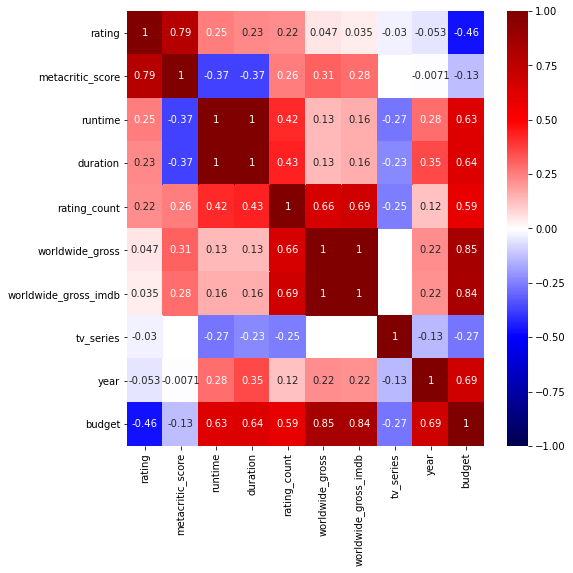

In [93]:
ix = films_df_reordered.iloc[:,:first_cast_column].corr().sort_values('rating', ascending=False).index
films_df_reordered_sorted = films_df_reordered.loc[:, ix]
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(films_df_reordered_sorted.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1, ax=ax);

In [94]:
#sns.heatmap(films_df_reordered.iloc[:,:first_cast_column].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

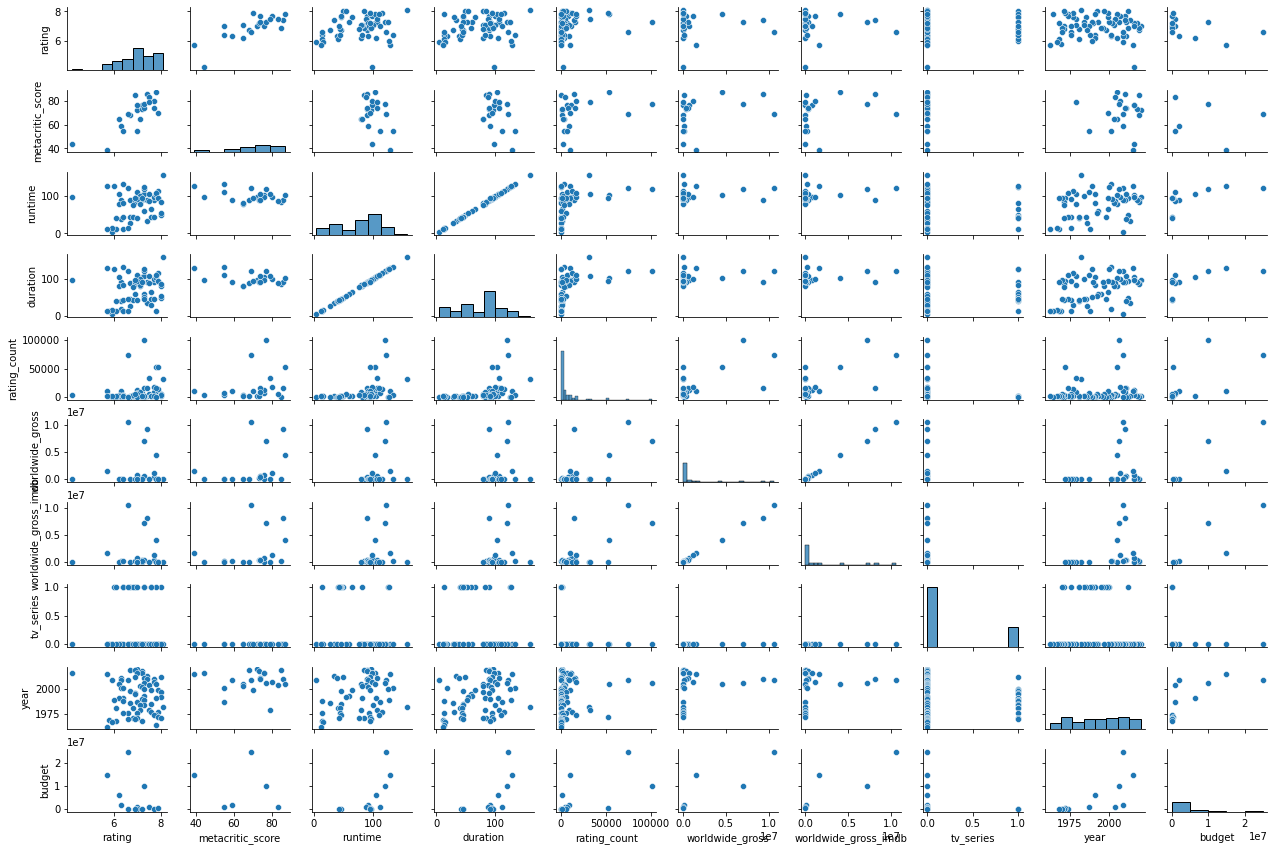

In [95]:
sns.pairplot(films_df_reordered_sorted.iloc[:,:first_cast_column], height=1.2, aspect=1.5);

#### Determine which columns have enough non-null values so they could be used

In [96]:
films_df_reordered['worldwide_gross'].value_counts(dropna=False)

NaN           47
2874.0         5
80636.0        1
37041.0        1
338987.0       1
1205464.0      1
765796.0       1
1578543.0      1
10606422.0     1
6970.0         1
76739.0        1
550645.0       1
9369629.0      1
23888.0        1
3126.0         1
4504451.0      1
7402.0         1
4861.0         1
7037886.0      1
327912.0       1
62221.0        1
78100.0        1
Name: worldwide_gross, dtype: int64

In [97]:
films_to_analyze=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['rating'].notnull()) & (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]
films_to_analyze.iloc[:,5:15].head(10)


,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,rating_count,tv_series,documentary,cinematographer
1,NaN,NaN,NaN,NaN,7.0,72.0,1439.0,0.0,1.0,Peter Zeitlinger
2,NaN,3126.0,3126.0,NaN,6.7,68.0,1913.0,0.0,0.0,Werner Herzog
3,NaN,78100.0,78100.0,NaN,6.9,85.0,551.0,0.0,1.0,Louis Caulfield
4,NaN,327912.0,319230.0,327912.0,7.2,73.0,1694.0,0.0,1.0,Yuri Burak
5,NaN,4861.0,3679.0,4861.0,7.2,76.0,7392.0,0.0,1.0,Peter Zeitlinger
6,NaN,23888.0,23888.0,NaN,4.2,44.0,2458.0,0.0,0.0,Peter Zeitlinger
7,NaN,765796.0,765796.0,NaN,7.0,76.0,11929.0,0.0,1.0,Peter Zeitlinger
8,15000000.0,1578543.0,1592853.0,1578543.0,5.7,39.0,10262.0,0.0,0.0,Peter Zeitlinger
9,NaN,NaN,NaN,NaN,8.0,NaN,1090.0,1.0,1.0,Peter Zeitlinger
10,NaN,NaN,NaN,NaN,7.4,NaN,1169.0,0.0,1.0,Peter Zeitlinger


In [98]:
len(dict_of_all_actors)

552

In [99]:
films_to_analyze.shape

(60, 567)

In [100]:
len(cast_column_names)

552

In [101]:
dict_of_all_actors

{'Werner Herzog': 1,
 'Clive Oppenheimer': 1,
 'Simon Schaffer': 1,
 'Jon Larsen': 1,
 'Jan Braly Kihle': 1,
 'Paul Steinhardt': 1,
 'Laurence Garvie': 1,
 'Meenakshi Wadhwa': 1,
 'Nita Sahai': 1,
 'Fátima Tec Pool': 1,
 'Guy Consolmagno': 1,
 'Donna Rohrer': 1,
 'Joanna Bulger': 1,
 'Mark Willman': 1,
 'Rob Weryk': 1,
 'Ishii Yuichi': 1,
 'Mahiro Tanimoto': 1,
 'Miki Fujimaki': 1,
 'Takashi Nakatani': 1,
 'Kumi Manda': 1,
 'Yuka Watanabe': 1,
 'Jin Kuroinu': 1,
 'Airi Coats': 1,
 'Shun Ishigaki': 1,
 'Tatsuaki Hôjô': 1,
 'Tetsuro Mori': 1,
 'Ryoko Sugimachi': 1,
 'Airi Asoh': 1,
 'Yuki Wakabayashi': 1,
 'Umetani Hideyasu': 1,
 'Bruce Chatwin': 1,
 'Karin Eberhard': 1,
 'Nicholas Shakespeare': 1,
 'Elizabeth Chatwin': 1,
 'Petronella Vaarzon-Morel': 1,
 'Glenn Morrison': 1,
 'Michael Liddle Pula': 1,
 'Marcus Wheeler': 1,
 'Shaun Angeles Penange': 1,
 'Peter Bartlett': 1,
 'Robin Granites': 1,
 'Stefan Glowacz': 1,
 'Alberto Del Castillo': 1,
 'Yuri Andropov': 1,
 'James Baker III': 1,

In [102]:
first_actor_column = (len(films_to_analyze.columns) - len(dict_of_all_actors))
first_actor_column

15

In [103]:
actor_columns = films_to_analyze.iloc[:, first_actor_column:-1].columns
actor_columns

Index(['Werner Herzog', 'Klaus Kinski', 'Volker Prechtel', 'Brad Dourif',
       'Wolfgang von Ungern-Sternberg', 'Paul Hittscher', 'Peter Berling',
       'Clemens Scheitz', 'Michael Shannon', 'Eva Mattes',
       ...
       'Jan Pawlowski', 'Samuel S. Bowser', 'David R. Pacheco Jr.',
       'Regina Eisert', 'Olav T. Oftedal', 'Kevin Emery', 'Ryan Andrew Evans',
       'Doug MacAyeal', 'Stefan Pashov', 'Scott Rowland'],
      dtype='object', length=551)

In [104]:
films_to_analyze[actor_columns].sum()

Werner Herzog                    26.0
Klaus Kinski                      6.0
Volker Prechtel                   4.0
Brad Dourif                       4.0
Wolfgang von Ungern-Sternberg     2.0
                                 ... 
Kevin Emery                       1.0
Ryan Andrew Evans                 1.0
Doug MacAyeal                     1.0
Stefan Pashov                     1.0
Scott Rowland                     1.0
Length: 551, dtype: float64

In [105]:
actors_num_of_appearances = films_to_analyze[actor_columns].sum()
actors_num_of_appearances

Werner Herzog                    26.0
Klaus Kinski                      6.0
Volker Prechtel                   4.0
Brad Dourif                       4.0
Wolfgang von Ungern-Sternberg     2.0
                                 ... 
Kevin Emery                       1.0
Ryan Andrew Evans                 1.0
Doug MacAyeal                     1.0
Stefan Pashov                     1.0
Scott Rowland                     1.0
Length: 551, dtype: float64

In [106]:
appearances_threshold = 3

In [107]:
actors_num_of_appearances

Werner Herzog                    26.0
Klaus Kinski                      6.0
Volker Prechtel                   4.0
Brad Dourif                       4.0
Wolfgang von Ungern-Sternberg     2.0
                                 ... 
Kevin Emery                       1.0
Ryan Andrew Evans                 1.0
Doug MacAyeal                     1.0
Stefan Pashov                     1.0
Scott Rowland                     1.0
Length: 551, dtype: float64

In [108]:
#actors_num_of_appearances[200:]

In [109]:
#actors_num_of_appearances.where(actors_num_of_appearances >= appearances_threshold)

In [110]:
actors_num_of_appearances >= appearances_threshold

Werner Herzog                     True
Klaus Kinski                      True
Volker Prechtel                   True
Brad Dourif                       True
Wolfgang von Ungern-Sternberg    False
                                 ...  
Kevin Emery                      False
Ryan Andrew Evans                False
Doug MacAyeal                    False
Stefan Pashov                    False
Scott Rowland                    False
Length: 551, dtype: bool

In [111]:

prevalent_actors_mask = (actors_num_of_appearances >= appearances_threshold)
prevalent_actors_mask

Werner Herzog                     True
Klaus Kinski                      True
Volker Prechtel                   True
Brad Dourif                       True
Wolfgang von Ungern-Sternberg    False
                                 ...  
Kevin Emery                      False
Ryan Andrew Evans                False
Doug MacAyeal                    False
Stefan Pashov                    False
Scott Rowland                    False
Length: 551, dtype: bool

In [112]:
prevalent_actor_columns = actor_columns[prevalent_actors_mask]
prevalent_actor_columns 

Index(['Werner Herzog', 'Klaus Kinski', 'Volker Prechtel', 'Brad Dourif',
       'Peter Berling', 'Clemens Scheitz', 'Michael Shannon', 'Eva Mattes'],
      dtype='object')

In [113]:
actor_columns

Index(['Werner Herzog', 'Klaus Kinski', 'Volker Prechtel', 'Brad Dourif',
       'Wolfgang von Ungern-Sternberg', 'Paul Hittscher', 'Peter Berling',
       'Clemens Scheitz', 'Michael Shannon', 'Eva Mattes',
       ...
       'Jan Pawlowski', 'Samuel S. Bowser', 'David R. Pacheco Jr.',
       'Regina Eisert', 'Olav T. Oftedal', 'Kevin Emery', 'Ryan Andrew Evans',
       'Doug MacAyeal', 'Stefan Pashov', 'Scott Rowland'],
      dtype='object', length=551)

#### These next few cells are legacy  -----------------------------------------

#### End of legacy code  -----------------------------------------

In [114]:
analysis_columns = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', *prevalent_actor_columns]

In [115]:
analysis_columns

['title',
 'year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'rating_count',
 'Werner Herzog',
 'Klaus Kinski',
 'Volker Prechtel',
 'Brad Dourif',
 'Peter Berling',
 'Clemens Scheitz',
 'Michael Shannon',
 'Eva Mattes']

## Dataset partitioned for analysis

In [116]:
films_and_features_to_analyze_df = films_to_analyze[analysis_columns]

In [117]:
x_label = 'year'
y_label = 'rating'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

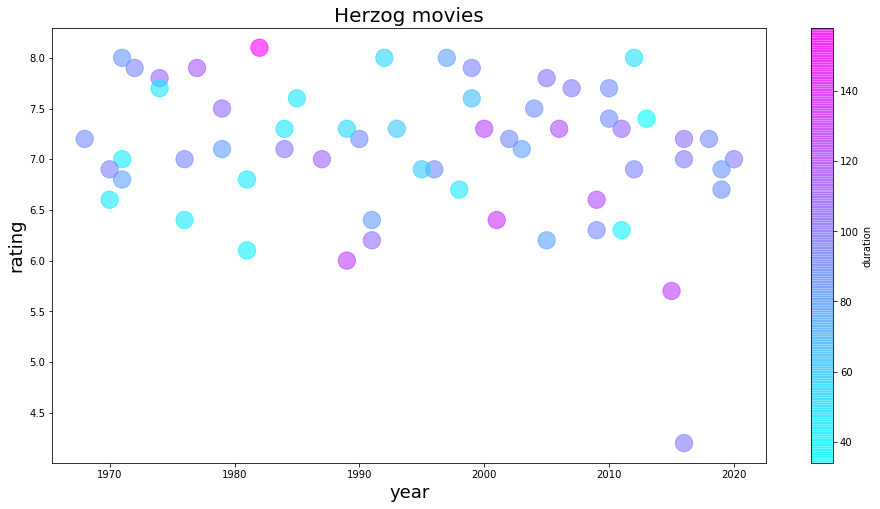

In [118]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'duration'
cm=films_and_features_to_analyze_df[color_dimension].tolist()

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension)

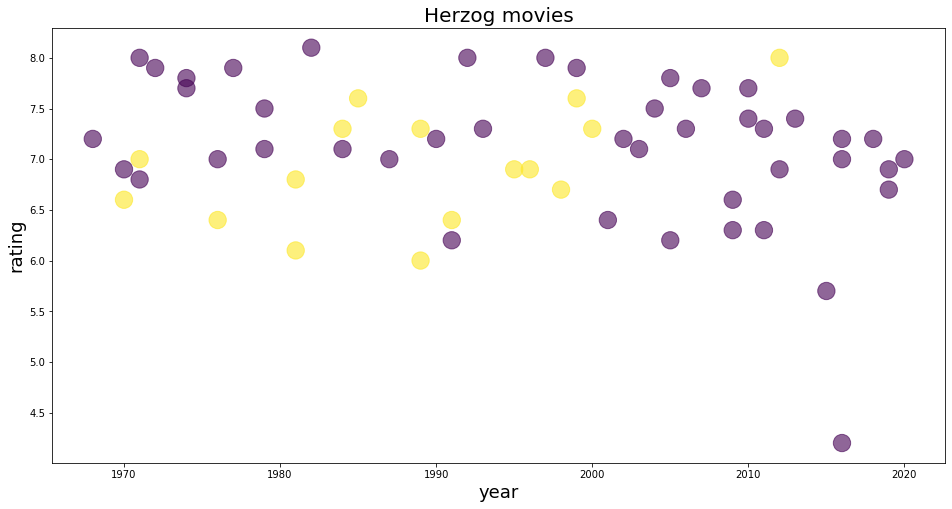

In [119]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))

In [120]:
x_label = 'year'
y_label = 'duration'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

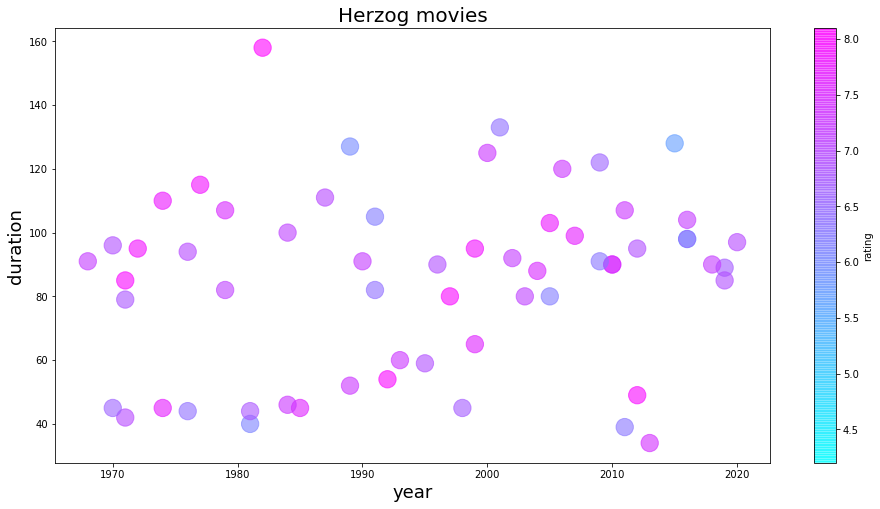

In [121]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'rating'
cm=films_and_features_to_analyze_df[color_dimension ].tolist()
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )

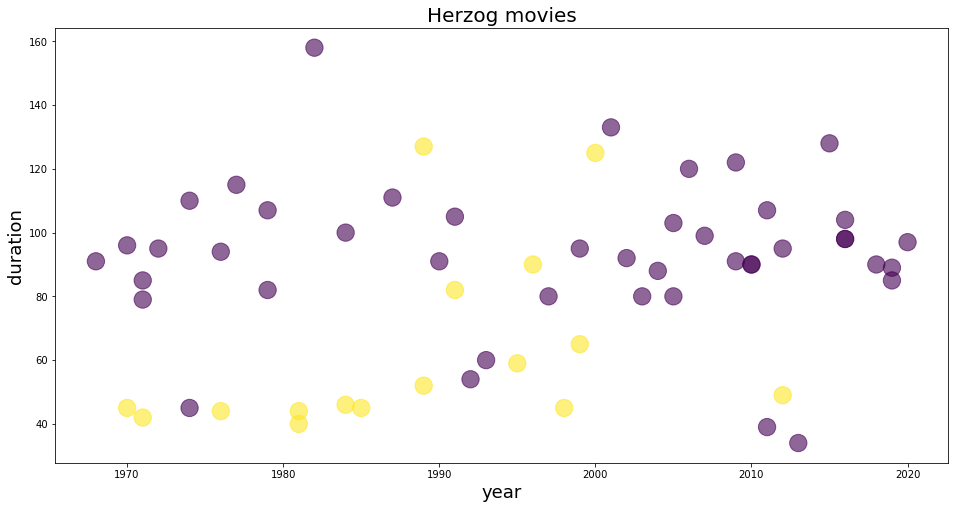

In [122]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))


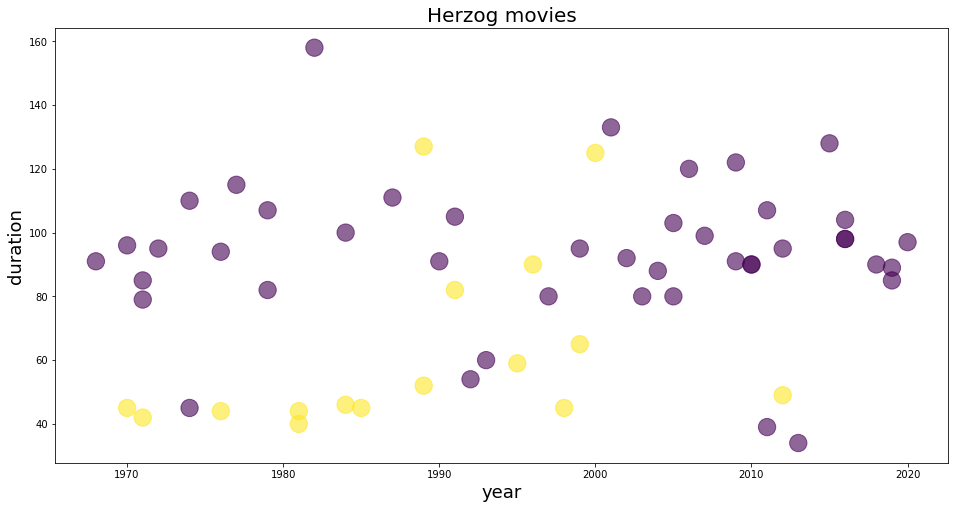

In [123]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))


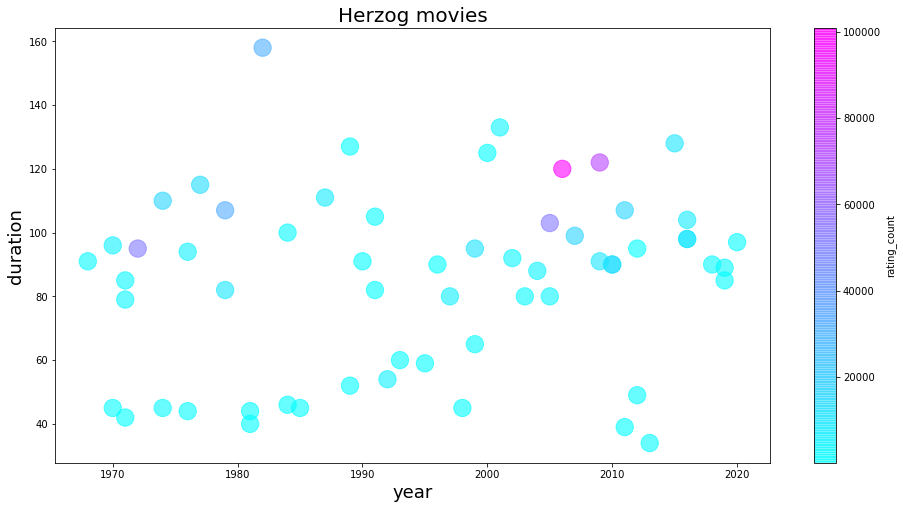

In [124]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'rating_count'
cmap=plt.get_cmap("cool")
cm=films_and_features_to_analyze_df[color_dimension ].tolist()
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )
#plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))

In [125]:
x_label = 'year'
y_label = 'rating_count'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

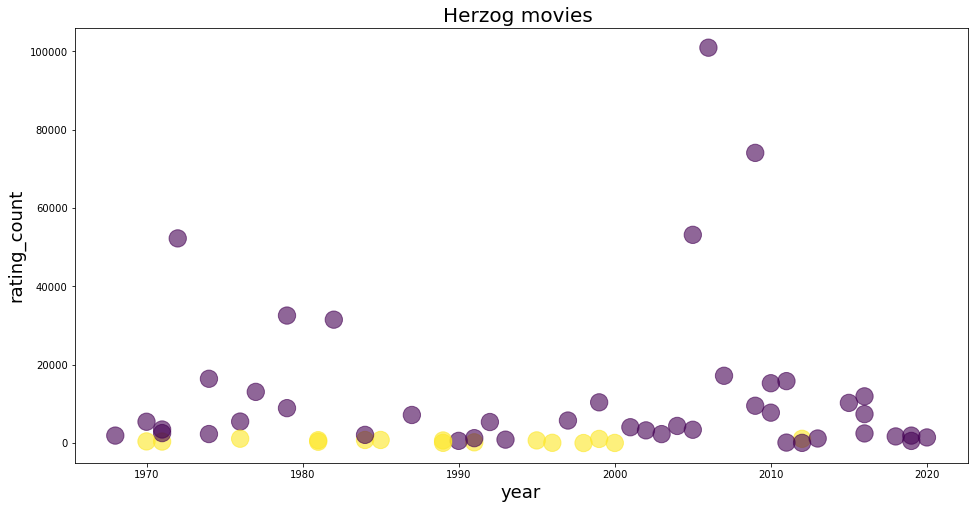

In [126]:
plt.figure(figsize=(16,8))
size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies ', fontsize='20')
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))


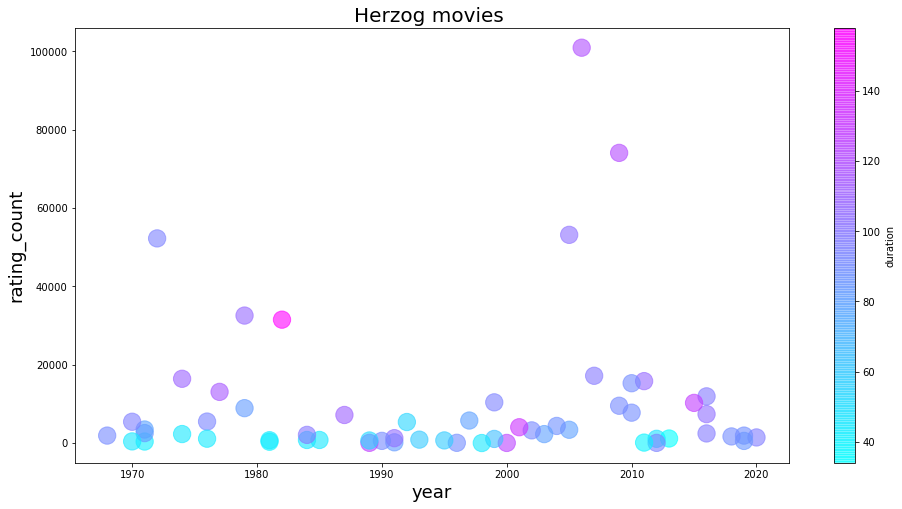

In [127]:
plt.figure(figsize=(16,8))
size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies ', fontsize='20')
color_dimension = 'duration'

cm=films_and_features_to_analyze_df[color_dimension ].tolist()
cmap=plt.get_cmap("cool")
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )

In [128]:
#films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1]

In [129]:
x_label = 'year'
y_label = 'rating_count'
x_ = films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1][x_label]
y_ = films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1][y_label]

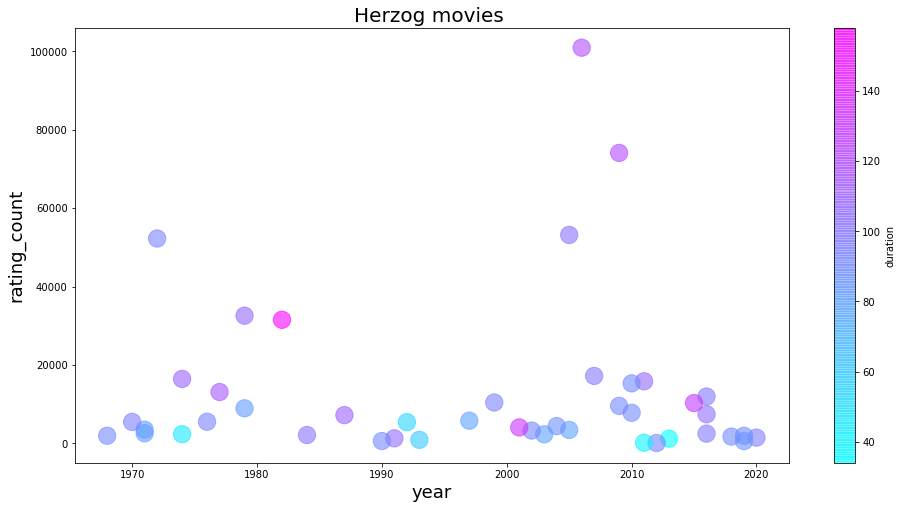

In [130]:
plt.figure(figsize=(16,8))
size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies ', fontsize='20')
color_dimension = 'duration'

cm=films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1][color_dimension ].tolist()
cmap=plt.get_cmap("cool")
#category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )

In [131]:
print( min(x_), max(x_))

1968.0 2020.0


In [132]:
from scipy import signal
signal.unit_impulse(1960) # come back to this to attempt to model "dirac impulse response" 
# for rating count based on year

array([1., 0., 0., ..., 0., 0., 0.])

In [133]:
films_and_features_to_analyze_df[films_and_features_to_analyze_df['duration'] <65]

,title,year,duration,cinematographer,documentary,tv_series,rating,rating_count,Werner Herzog,Klaus Kinski,Volker Prechtel,Brad Dourif,Peter Berling,Clemens Scheitz,Michael Shannon,Eva Mattes
9,On Death Row,2012.0,49.0,Peter Zeitlinger,1.0,1.0,8.0,1090.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,From One Second to the Next,2013.0,34.0,Peter Zeitlinger,1.0,0.0,7.4,1169.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,Ode to the Dawn of Man,2011.0,39.0,Werner Herzog,1.0,0.0,6.3,127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,Höllenfahrten,1998.0,45.0,Lars Barthel,1.0,1.0,6.7,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,Tod für fünf Stimmen,1995.0,59.0,Peter Zeitlinger,1.0,1.0,6.9,679.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,Glocken aus der Tiefe - Glaube und Aberglaube ...,1993.0,60.0,Jörg Schmidt-Reitwein,1.0,0.0,7.3,878.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,Lektionen in Finsternis,1992.0,54.0,Paul Berriff,1.0,0.0,8.0,5376.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,Wodaabe - Die Hirten der Sonne. Nomaden am Süd...,1989.0,52.0,Jörg Schmidt-Reitwein,1.0,1.0,7.3,665.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,Gasherbrum - Der leuchtende Berg,1985.0,45.0,Rainer Klausmann,1.0,1.0,7.6,796.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47,Ballade vom kleinen Soldaten,1984.0,46.0,Michael Edols,1.0,1.0,7.3,792.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Breakdown by **cinematographers** Jack E. Cox, Robert Burks, and Bernard Knowles 

In [134]:
cinematographer = 'Jack E. Cox'

In [135]:
ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


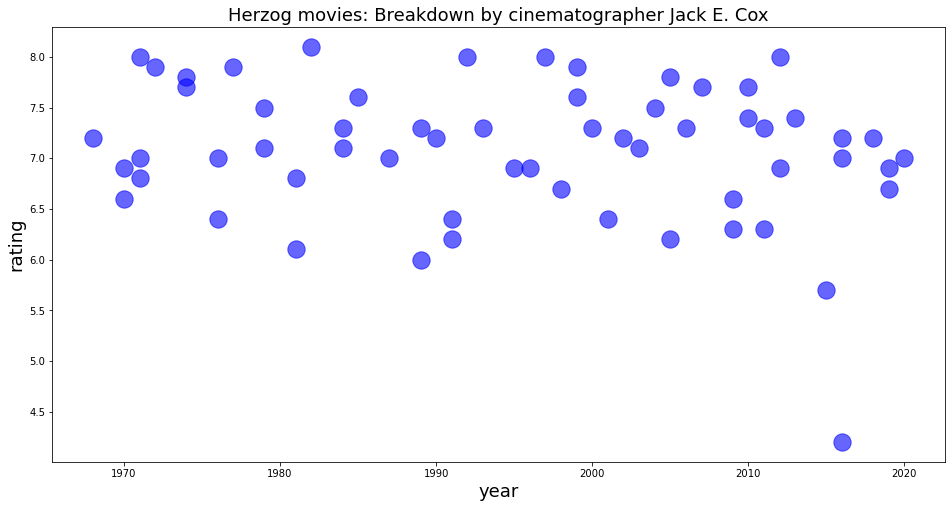

In [136]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

In [137]:
cinematographer = 'Robert Burks'

In [138]:

ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


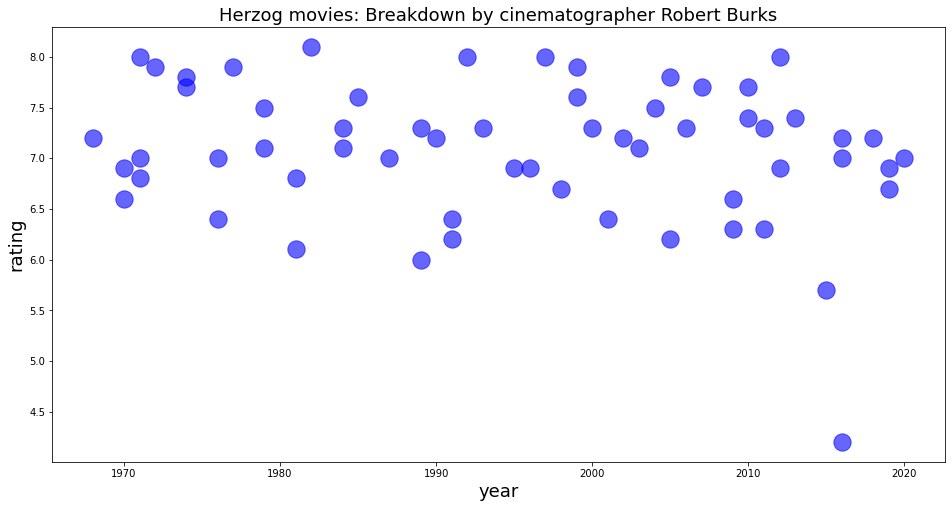

In [139]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

In [140]:
cinematographer = 'Bernard Knowles'

In [141]:

ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


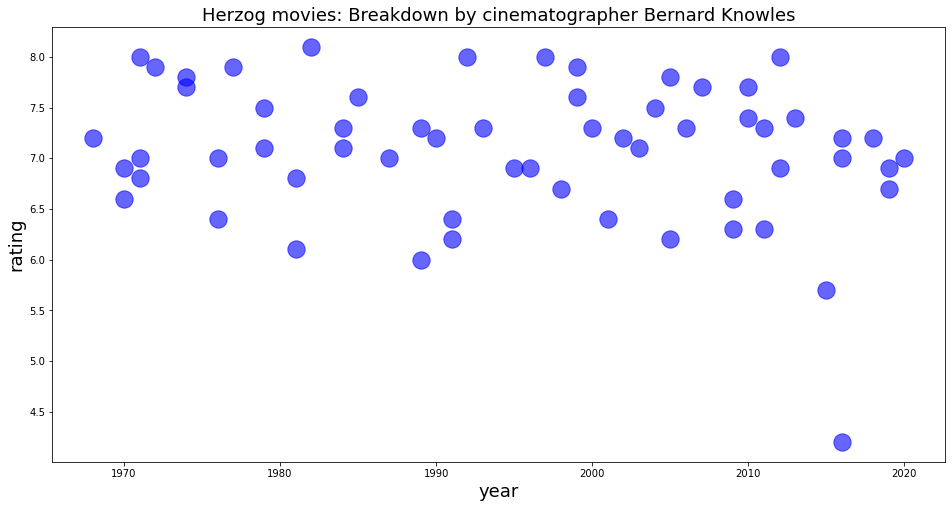

In [142]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: ' + 'Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

#### Recode misc. cinematographers to `OTHER` to ameliorate issue of not dropping a column and also to increase the chance it will occur in the test set as well

In [143]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

1

In [144]:
value_counts = films_and_features_to_analyze_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Regression analysis on `rating`,  `duration`, and `year` etc

#### `rating` as target

### Train Test Split

In [145]:
films_and_features_to_analyze_df.columns # review columns we start with

Index(['title', 'year', 'duration', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'rating_count', 'Werner Herzog', 'Klaus Kinski',
       'Volker Prechtel', 'Brad Dourif', 'Peter Berling', 'Clemens Scheitz',
       'Michael Shannon', 'Eva Mattes'],
      dtype='object')

In [146]:
selected_cols = [*films_and_features_to_analyze_df.columns[1:6], *films_and_features_to_analyze_df.columns[7:]]

In [147]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Preprocessing

#### Categorical Variable Preprocessing

In [149]:
cat_ohe_vars = ['cinematographer']
X_train_cat_ohe = X_train[cat_ohe_vars]
#X_train_cat_ohe 

#### OneHotEncoding

In [150]:
#ohe = OneHotEncoder(sparse=False, drop='first')
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_cat_ohe)
cats_ohe = ohe.transform(X_train_cat_ohe)


In [151]:
columns=ohe.get_feature_names(cat_ohe_vars)

columns

array(['cinematographer_Henning Brümmer',
       'cinematographer_Jörg Schmidt-Reitwein', 'cinematographer_OTHER',
       'cinematographer_Peter Zeitlinger',
       'cinematographer_Rainer Klausmann', 'cinematographer_Thomas Mauch',
       'cinematographer_Werner Herzog'], dtype=object)

In [152]:
X_train_cat_ohe_df = pd.DataFrame(cats_ohe, columns=columns, index=X_train_cat_ohe.index)
X_train_cat_ohe_df.head()

,cinematographer_Henning Brümmer,cinematographer_Jörg Schmidt-Reitwein,cinematographer_OTHER,cinematographer_Peter Zeitlinger,cinematographer_Rainer Klausmann,cinematographer_Thomas Mauch,cinematographer_Werner Herzog
64,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0
11,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Repeating transformations on testing set

In [153]:
X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cats_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cats_ohe_test, columns=cat_ohe_columns)

### Continous Variable Preprocessing

#### Select continuous variables from training set

In [154]:
X_train_cont = X_train[['year', 'duration', 'rating_count']]
X_train_cont.head(70)



,year,duration,rating_count
64,1971.0,79.0,3466.0
10,2013.0,34.0,1169.0
18,2009.0,122.0,74092.0
6,2016.0,98.0,2458.0
11,2012.0,95.0,54.0
3,2019.0,85.0,551.0
42,1989.0,52.0,665.0
57,1976.0,94.0,5495.0
8,2015.0,128.0,10262.0
65,1970.0,96.0,5446.0


####  scale the continuous variables in the train set

In [155]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()


,year,duration,rating_count
64,-1.352724,-0.324834,-0.369225
10,1.093829,-1.925295,-0.486343
18,0.860824,1.204495,3.231806
6,1.268583,0.350916,-0.420621
11,1.035578,0.244218,-0.543194


#### select and scale the continuous variables in the test set

In [156]:
X_test_cont = X_test[['year', 'duration', 'rating_count']]
X_test_cont.head()

,year,duration,rating_count
47,1984.0,46.0,792.0
48,1984.0,100.0,2095.0
58,1976.0,44.0,1116.0
32,1997.0,80.0,5757.0
13,2011.0,39.0,127.0


In [157]:
X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count
47,-0.595457,-1.498506,-0.505565
48,-0.595457,0.422047,-0.439129
58,-1.061468,-1.569637,-0.489046
32,0.161809,-0.289269,-0.252413
13,0.977327,-1.747466,-0.539472


### Combine the continuous, categorical, and ohe cat features for our testing set


In [158]:
cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_cat_df = X_train[cat_columns]


In [159]:
X_train_combined = pd.concat([X_train_scaled_df, X_train_cat_ohe_df, X_train_cat_df, ], axis='columns')

X_train_combined.head(10)

,year,duration,rating_count,cinematographer_Henning Brümmer,cinematographer_Jörg Schmidt-Reitwein,cinematographer_OTHER,cinematographer_Peter Zeitlinger,cinematographer_Rainer Klausmann,cinematographer_Thomas Mauch,cinematographer_Werner Herzog,documentary,tv_series,Werner Herzog,Klaus Kinski,Volker Prechtel,Brad Dourif,Peter Berling,Clemens Scheitz,Michael Shannon,Eva Mattes
64,-1.352724,-0.324834,-0.369225,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1.093829,-1.925295,-0.486343,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.860824,1.204495,3.231806,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6,1.268583,0.350916,-0.420621,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11,1.035578,0.244218,-0.543194,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.443337,-0.111440,-0.517853,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,-0.304201,-1.285111,-0.512041,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57,-1.061468,0.208653,-0.265772,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8,1.210332,1.417890,-0.022715,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65,-1.410975,0.279784,-0.268270,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [160]:
X_train.shape

(45, 14)

### Combine the continuous and categorical features for our testing set


In [161]:
X_test_cat_df = X_test[cat_columns]

In [162]:
X_test_scaled_df.shape[0] == X_test_cat_df.shape[0] == X_test_cat_ohe_df.shape[0]


True

In [163]:
X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True) ], axis=1)
#X_test_combined = pd.concat([X_test_scaled_df, X_test_cat_ohe_df, X_test_cat_df ], axis=1)

X_test_combined

,year,duration,rating_count,cinematographer_Henning Brümmer,cinematographer_Jörg Schmidt-Reitwein,cinematographer_OTHER,cinematographer_Peter Zeitlinger,cinematographer_Rainer Klausmann,cinematographer_Thomas Mauch,cinematographer_Werner Herzog,documentary,tv_series,Werner Herzog,Klaus Kinski,Volker Prechtel,Brad Dourif,Peter Berling,Clemens Scheitz,Michael Shannon,Eva Mattes
0,-0.595457,-1.498506,-0.505565,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.595457,0.422047,-0.439129,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.061468,-1.569637,-0.489046,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.161809,-0.289269,-0.252413,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.977327,-1.747466,-0.539472,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.071196,-1.000585,-0.501181,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.569568,-0.004742,-0.322827,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.304201,1.382324,-0.542735,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.453065,0.137521,-0.380646,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.511317,-0.289269,-0.429237,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Now make predictions by instantiating the Linear Regression Model 

In [164]:
lr = LinearRegression()

lr.fit(X_train_combined, y_train)

LinearRegression()

In [165]:
lr.coef_

array([-0.45496389, -0.1330661 ,  0.25375157,  0.79633418, -0.12829955,
       -0.16896754,  0.11376598, -0.89643619, -0.44579906,  0.72940218,
        0.29154234, -0.3028192 ,  0.77455403, -0.33340296, -0.23281115,
        0.593997  ,  1.14382804,  0.48923   , -1.26062535,  0.62105207])

In [166]:
y_pred = lr.predict(X_test_combined)

y_pred

array([7.68148354, 6.7201722 , 7.63032696, 7.82583662, 7.41708276,
       7.72130696, 8.2671609 , 6.09010338, 6.25516502, 7.62195389,
       8.11833911, 6.53052631, 7.48024462, 6.82850374, 7.17724084])

In [167]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.62
r2: -0.07


In [168]:
print(r2)

-0.06766282040660032


In [169]:
score = lr.score(X_test_combined, y_test) 
score

-0.06766282040660032

# Focus on building up from fewer features

### Train Test Split

In [170]:
films_and_features_to_analyze_df.columns # review columns we start with

Index(['title', 'year', 'duration', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'rating_count', 'Werner Herzog', 'Klaus Kinski',
       'Volker Prechtel', 'Brad Dourif', 'Peter Berling', 'Clemens Scheitz',
       'Michael Shannon', 'Eva Mattes'],
      dtype='object')

In [171]:
selected_cols = ['year', 'duration', 'rating_count']

In [172]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Preprocessing

## For now, ignore these categorical variables

#### Categorical Variable Preprocessing

#### OneHotEncoding

#### Repeating transformations on testing set

### Continous Variable Preprocessing

#### Select continuous variables from training set

In [174]:
X_train_cont = X_train[['year', 'duration', 'rating_count']]
X_train_cont.head()



,year,duration,rating_count
11,2012.0,95.0,54.0
39,1991.0,105.0,1253.0
48,1984.0,100.0,2095.0
4,2018.0,90.0,1694.0
21,2005.0,80.0,3401.0


####  scale the continuous variables in the train set

In [175]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()


,year,duration,rating_count
11,1.021309,0.317421,-0.528029
39,-0.253641,0.664118,-0.470055
48,-0.678624,0.490769,-0.429342
4,1.385580,0.144072,-0.448731
21,0.596326,-0.202625,-0.366194


#### select and scale the continuous variables in the test set

In [176]:
X_test_cont = X_test[['year', 'duration', 'rating_count']]
X_test_cont.head()

,year,duration,rating_count
6,2016.0,98.0,2458.0
42,1989.0,52.0,665.0
40,1990.0,91.0,566.0
62,1971.0,42.0,393.0
63,1971.0,85.0,2546.0


In [177]:
X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count
6,1.264156,0.421430,-0.411790
42,-0.375065,-1.173378,-0.498486
40,-0.314353,0.178742,-0.503273
62,-1.467878,-1.520075,-0.511638
63,-1.467878,-0.029277,-0.407535


### Combine the continuous, categorical, and ohe cat features for our testing set


## for now, ignore these categorical variables

## 'combine' will really just be the continuous variables

In [178]:
X_train_combined = pd.concat([X_train_scaled_df.reset_index(drop=True)], axis='columns')

X_train_combined.head()

,year,duration,rating_count
0,1.021309,0.317421,-0.528029
1,-0.253641,0.664118,-0.470055
2,-0.678624,0.490769,-0.429342
3,1.385580,0.144072,-0.448731
4,0.596326,-0.202625,-0.366194


In [179]:
X_train_combined.shape

(45, 3)

### Combine the continuous and categorical features for our testing set


In [180]:
#X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True) ], axis=1)
X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True) ], axis=1)

X_test_combined

,year,duration,rating_count
0,1.264156,0.421430,-0.411790
1,-0.375065,-1.173378,-0.498486
2,-0.314353,0.178742,-0.503273
3,-1.467878,-1.520075,-0.511638
4,-1.467878,-0.029277,-0.407535
5,0.414190,0.213411,-0.373882
6,0.110631,-0.202625,-0.252275
7,0.535614,0.074733,-0.319050
8,0.353478,1.634870,-0.335151
9,-1.164319,-1.450736,-0.476679


### Now make predictions by instantiating the Linear Regression Model 

In [181]:
#X_train_combined

In [182]:
lr = LinearRegression()

lr.fit(X_train_combined,y_train)

LinearRegression()

In [183]:
lr.coef_

array([-0.1036113 , -0.03659285,  0.155751  ])

In [184]:

y_pred = lr.predict(X_test_combined)

y_pred

array([6.85612777, 7.07082516, 7.01431126, 7.19469126, 7.15635282,
       6.95771014, 7.02332662, 6.95874401, 6.91801763, 7.16614662,
       7.01662975, 7.02235865, 7.02667442, 7.08489479, 6.97676031])

In [185]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.92
r2: 0.07


In [186]:
score = lr.score(X_test_combined, y_test) 
score

0.07241776881345441

## Try to fit with just the year

In [187]:
lr = LinearRegression()

In [188]:
X_train_year_only = X_train_combined.iloc[:, :1]

In [189]:
X_test_year_only = X_test_combined.iloc[:, :1]

In [190]:
#X_train_year_only 

In [191]:
lr.fit(X_train_year_only, y_train)

LinearRegression()

In [192]:
lr.coef_

array([-0.1008267])

In [193]:
y_pred = lr.predict(X_test_year_only)

y_pred

array([6.93920595, 7.10448319, 7.09836181, 7.21466801, 7.21466801,
       7.02490526, 7.05551215, 7.0126625 , 7.03102664, 7.18406112,
       7.09224043, 6.99429836, 7.0432694 , 7.08611905, 6.96981285])

In [194]:
y_test

6     4.2
42    7.3
40    7.2
62    7.0
63    8.0
25    7.2
32    8.0
23    7.5
27    6.4
58    6.4
38    6.4
19    7.7
30    7.9
36    8.0
12    7.3
Name: rating, dtype: float64

In [195]:
#y_test

In [196]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [197]:
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.93
r2: 0.04


## Try to fit with just the `year` and `duration`


In [198]:
lr = LinearRegression()

X_train_year_dur_only = X_train_combined.iloc[:, :2]

X_test_year_dur_only = X_test_combined.iloc[:, :2]

#X_train_year_only 

lr.fit(X_train_year_dur_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_year_dur_only)

y_pred

y_test

#y_test

from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.94
r2: 0.03


## Try to fit with just the `year` and `rating_count`

In [199]:
X_train_combined[['year', 'rating_count']]

,year,rating_count
0,1.021309,-0.528029
1,-0.253641,-0.470055
2,-0.678624,-0.429342
3,1.385580,-0.448731
4,0.596326,-0.366194
5,-0.375065,-0.527594
6,-0.800048,0.992897
7,0.292766,-0.528851
8,-1.407167,1.995969
9,0.474902,-0.419961


In [200]:
lr = LinearRegression()

X_train_year_rc_only = X_train_combined[['year', 'rating_count']]

X_test_year_rc_only = X_test_combined[['year', 'rating_count']]



lr.fit(X_train_year_rc_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_year_rc_only)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.92
r2: 0.06


## Feature engineer: include log(`year`) and and log(`rating_count`)

####  scale the continuous variables in the train set

In [201]:
X_train_cont_w_log = copy.deepcopy(X_train_cont) 
X_test_cont_w_log = copy.deepcopy(X_test_cont) 

X_train_cont_w_log['log_year'] = np.log(X_train_cont_w_log.year)
X_test_cont_w_log['log_year'] = np.log(X_test_cont_w_log.year)

X_train_cont_w_log['log_rating_count'] = np.log(X_train_cont_w_log.rating_count)
X_test_cont_w_log['log_rating_count'] = np.log(X_test_cont_w_log.rating_count)

In [202]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont_w_log)
X_train_scaled = ss.transform(X_train_cont_w_log)

cont_columns = X_train_cont_w_log.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()

,year,duration,rating_count,log_year,log_rating_count
11,1.021309,0.317421,-0.528029,1.020759,-1.786485
39,-0.253641,0.664118,-0.470055,-0.249679,-0.276827
48,-0.678624,0.490769,-0.429342,-0.676139,-0.030037
4,1.385580,0.144072,-0.448731,1.381307,-0.132044
21,0.596326,-0.202625,-0.366194,0.598759,0.202591


In [203]:
X_test_scaled = ss.transform(X_test_cont_w_log)

cont_columns = X_test_cont_w_log.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count,log_year,log_rating_count
6,1.264156,0.421430,-0.411790,1.261244,0.046684
42,-0.375065,-1.173378,-0.498486,-0.371372,-0.580989
40,-0.314353,0.178742,-0.503273,-0.310510,-0.658382
62,-1.467878,-1.520075,-0.511638,-1.472141,-0.833523
63,-1.467878,-0.029277,-0.407535,-1.472141,0.063573


In [204]:
lr = LinearRegression()

lr.fit(X_train_scaled_df, y_train)

lr.coef_

y_pred = lr.predict(X_test_scaled_df)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.87
r2: 0.16


In [205]:
lr.coef_

array([-7.61822721, -0.07726244,  0.02700891,  7.53732857,  0.21218914])

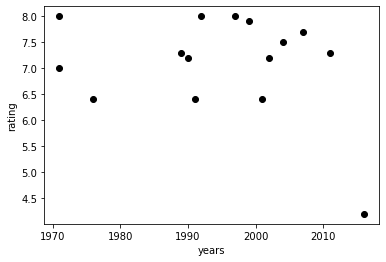

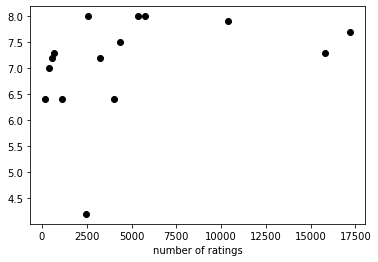

In [206]:
plt.ylabel("rating")
plt.scatter(X_test_cont_w_log['year'], y_test,  color='black')
plt.xlabel('years')
plt.show()
#plt.plot(X_test_cont_w_log['year'], y_pred, color='blue', linewidth=3)
plt.scatter(X_test_cont_w_log['rating_count'], y_test,  color='black')
plt.xlabel('number of ratings')
plt.show()

### Fit to only  `log_rating_count` and maybe `log_year`


In [207]:
lr = LinearRegression()

X_train_logs_only = X_train_scaled_df[['year','log_rating_count']]

X_test_logs_only = X_test_scaled_df[['year','log_rating_count']]



lr.fit(X_train_logs_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_logs_only)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.90
r2: 0.11


## Repartition data set to analyze `worldwide_gross`

In [208]:
films_df_reordered

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Samuel S. Bowser,David R. Pacheco Jr.,Regina Eisert,Olav T. Oftedal,Kevin Emery,Ryan Andrew Evans,Doug MacAyeal,Stefan Pashov,Scott Rowland,Reinhard Lichtenberg
1,Fireball: Visitors from Darker Worlds,2020.0,13 November 2020 (Australia),97.0,97.0,NaN,NaN,NaN,NaN,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Family Romance, LLC",2019.0,3 July 2020 (USA),89.0,89.0,NaN,3126.0,3126.0,NaN,6.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Nomad: In the Footsteps of Bruce Chatwin,2019.0,26 August 2020 (USA),85.0,85.0,NaN,78100.0,78100.0,NaN,6.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Meeting Gorbachev,2018.0,3 May 2019 (USA),90.0,90.0,NaN,327912.0,319230.0,327912.0,7.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Into the Inferno,2016.0,28 October 2016 (USA),104.0,104.0,NaN,4861.0,3679.0,4861.0,7.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Lebenszeichen,1968.0,9 December 1981 (USA),91.0,95.0,25000.0,NaN,NaN,NaN,7.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,Letzte Worte,1968.0,26 November 1976 (USA),13.0,13.0,NaN,NaN,NaN,NaN,6.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,Die beispiellose Verteidigung der Festung Deut...,1967.0,1967 (West Germany),15.0,15.0,NaN,NaN,NaN,NaN,5.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,Spiel im Sand,1964.0,,14.0,NaN,NaN,NaN,NaN,NaN,7.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [209]:
films_to_analyze_profits=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['worldwide_gross'].notnull()) & (films_df_reordered['worldwide_gross']!='') & (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]
#films_to_analyze_profits=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['rating'].notnull()) & (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]

films_to_analyze_profits.iloc[:,8:15]


,worldwide_gross_bo,rating,metacritic_score,rating_count,tv_series,documentary,cinematographer
2,NaN,6.7,68.0,1913.0,0.0,0.0,Werner Herzog
3,NaN,6.9,85.0,551.0,0.0,1.0,Louis Caulfield
4,327912.0,7.2,73.0,1694.0,0.0,1.0,Yuri Burak
5,4861.0,7.2,76.0,7392.0,0.0,1.0,Peter Zeitlinger
6,NaN,4.2,44.0,2458.0,0.0,0.0,Peter Zeitlinger
7,NaN,7.0,76.0,11929.0,0.0,1.0,Peter Zeitlinger
8,1578543.0,5.7,39.0,10262.0,0.0,0.0,Peter Zeitlinger
12,550645.0,7.3,74.0,15816.0,0.0,1.0,Peter Zeitlinger
14,NaN,7.7,74.0,7766.0,0.0,1.0,Alexey Matveev
15,9369629.0,7.4,86.0,15280.0,0.0,1.0,Peter Zeitlinger


In [210]:
new_analysis_columns = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', 'worldwide_gross', *selected_actor_columns]

NameError: name 'selected_actor_columns' is not defined

In [ ]:
films_and_features_to_analyze_profits = films_to_analyze_profits[new_analysis_columns]

In [ ]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'rating'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'duration'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'rating_count'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'James Stewart'
plt.title(director.title() + ' movies: ' + 'Breakdown by actor: ' + category, fontsize='18')

plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'Cary Grant'
plt.title(director.title() + ' movies: ' + 'Breakdown by actor: ' + category, fontsize='18')

plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'Grace Kelly'
plt.title(director.title() + ' movies: ' + 'Breakdown by actor: ' + category, fontsize='18')

plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

### Repartition data set to analyze `worldwide_gross` in terms of `budget` etc.

In [ ]:

films_to_analyze_profits_and_budget=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['worldwide_gross'].notnull()) & (films_df_reordered['worldwide_gross']!='') & (films_df_reordered['budget'].notnull()) & (films_df_reordered['budget']!='')& (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]

films_to_analyze_profits_and_budget.iloc[:,8:15]
films_to_analyze_profits_and_budget


In [ ]:
new_analysis_columns_budget = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', 'budget', 'worldwide_gross', *selected_actor_columns]

In [ ]:
films_and_features_to_analyze_profits_and_budget = films_to_analyze_profits_and_budget[new_analysis_columns_budget]

In [ ]:
x_label = 'year'
y_label = 'budget'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))

In [ ]:
x_label = 'budget'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))

In [ ]:
x_label = 'budget'
y_label = 'duration'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))

In [ ]:
x_label = 'budget'
y_label = 'rating'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))